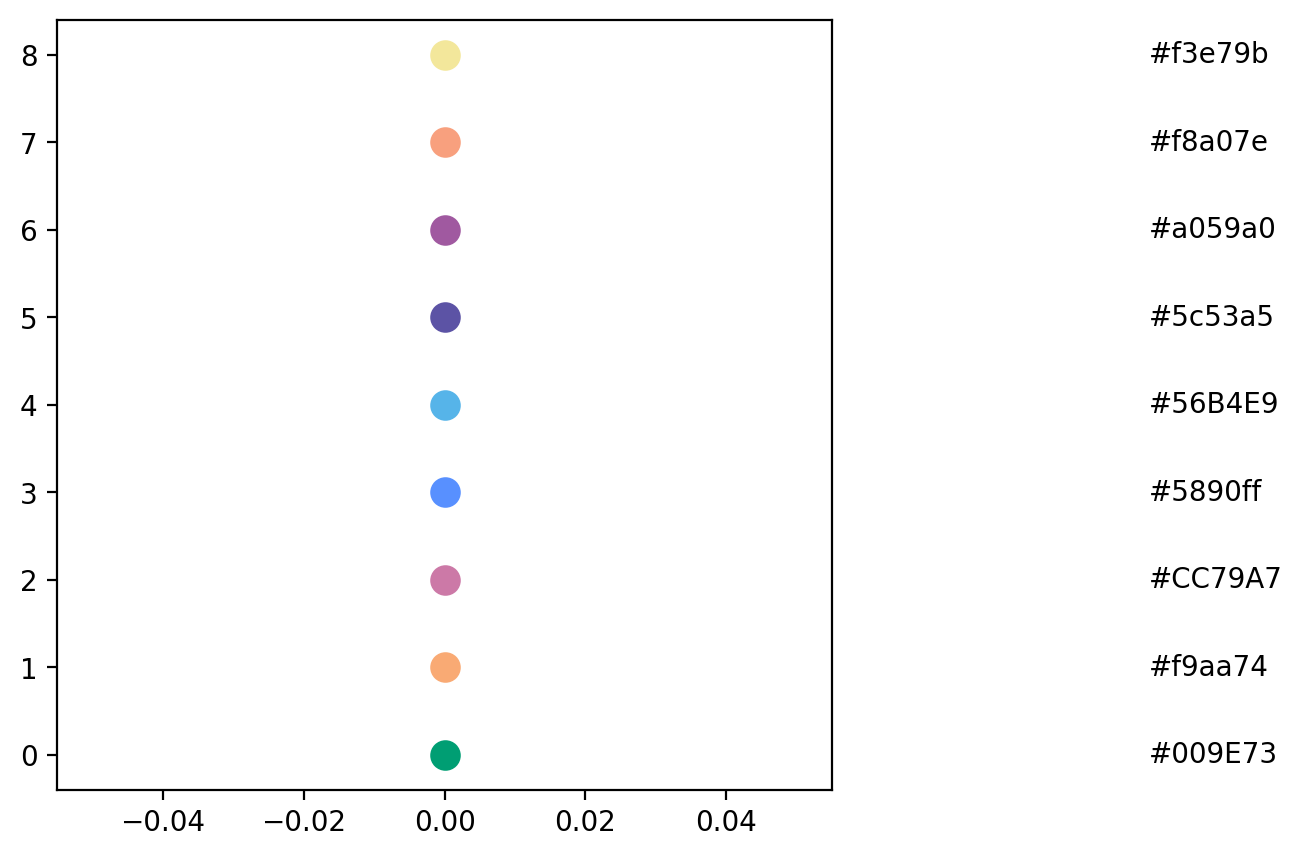

In [2]:
# plot each color on a dotplot"
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i, color in enumerate(my_categorical_palette):
    ax.scatter(0, i, color=color, s=100)
    ax.text(0.1, i, color, va='center')

# Read in Nebulas and mSalt

In [ ]:

#mSalt_across_species.scale_by_total_seq_depth()
#mSalt_across_species.log_scale_expr()
#mSalt_across_species.get_dream_gene_expression()
#mSalt_across_species.dream_enrichment_ssgsea()

In [ ]:
# read nebulas
loader = read_data.DatasetLoader("nebulas")
nebulas = loader.load_dataset()

# read mSalt
loader = read_data.DatasetLoader("mSalt")
mSalt_across_species = loader.load_dataset()
# add mSalt_across_species.expression_df to nebulas.expression_df, matching columns
nebulas.expression_df = pd.concat([nebulas.expression_df, mSalt_across_species.expression_df], axis=0, join="outer")
# same for metadata
nebulas.metadata_df = pd.concat([nebulas.metadata_df, mSalt_across_species.metadata_df], axis=0, join="outer")
# update meta_cols
nebulas.meta_cols = nebulas.metadata_df.columns.to_list()

nebulas.scale_by_total_seq_depth()
nebulas.log_scale_expr()
nebulas.get_dream_gene_expression()
nebulas.dream_enrichment_ssgsea()

# drop human samples bc we want to rely on gtex
nebulas.expression_df = nebulas.expression_df.query("Species != 'Homo sapiens'")
nebulas.dream_expression = nebulas.dream_expression.query("Species != 'Homo sapiens'")
nebulas.metadata_df = nebulas.metadata_df.query("Species != 'Homo sapiens'")


species_lifespans = pd.read_csv("/cellar/users/zkoch/dream/utilities/animal_lifespans.csv")
# join with dream_expression
nebulas.dream_expression = nebulas.dream_expression.merge(species_lifespans, left_on="Species", right_on="species", how = 'left')

# drop weird stuff
nebulas.dream_expression.query("Tissue != 'Mixed'", inplace=True)
# drop samples with fewer than 10k epxressed genes
nebulas.dream_expression.query("n_genes_expressed > 9999", inplace = True)
# select rows where Disease state is '-' or nan
"""nebulas.dream_expression.query("`Disease State` == '-' or `Disease State`.isna()", inplace=True)
# select rows where Case/Control contains 'ase' or is nan
nebulas.dream_expression.query("`Case/Control`.str.contains('ase', na=False) or `Case/Control`.isna()", inplace=True)"""

# read gtex
"""loader = read_data.DatasetLoader("gtex")
gtex_expr, gtex_mut = loader.load_dataset()
gtex_expr.scale_by_total_seq_depth()
gtex_expr.log_scale_expr()
gtex_expr.dream_expression = pd.read_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/gtex_expr_dream_expression_df_save.parquet")"""
"""gtex_expr.get_dream_gene_expression()
gtex_expr.dream_enrichment_ssgsea()
gtex_expr.dream_expression.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/gtex_expr_dream_expression_df_save.parquet")
"""
gtex_expr.dream_expression['Species'] = 'Homo sapiens'
gtex_expr.dream_expression['Tissue'] = gtex_expr.dream_expression['tissue']

nebulas.dream_expression['is_gtex'] = False
gtex_expr.dream_expression['is_gtex'] = True

# combine dream_expression dfs
nebulas.dream_expression = pd.concat([nebulas.dream_expression, gtex_expr.dream_expression], axis = 0, join='outer')
# re-join species info
nebulas.dream_expression.drop(columns = species_lifespans.columns[1:], inplace =True)
nebulas.dream_expression = nebulas.dream_expression.drop(columns=['species']).merge(species_lifespans, left_on="Species", right_on="species", how = 'outer')
# rescal
nebulas.scale_dream_by_seq_depth('DREAM_normalized_enrichment_score', eq='DREAM_normalized_enrichment_score ~ total_seq_depth * n_genes_expressed')

# drop rows with nan DREAM_normalized_enrichment_score_resid
nebulas.dream_expression.dropna(subset = ['DREAM_normalized_enrichment_score_resid'], inplace = True)

In [ ]:
nebulas.scale_dream_by_seq_depth('mean_dream_reg_expr', eq='mean_dream_reg_expr ~ total_seq_depth * n_genes_expressed')

In [ ]:
nebulas.dream_expression.groupby("Tissue")[[ 'total_seq_depth' ,'DREAM_normalized_enrichment_score']].corr(method = 'spearman')['DREAM_normalized_enrichment_score'].iloc[::2].describe()

In [ ]:
nebulas.dream_expression.groupby("Tissue")[['total_seq_depth' ,'DREAM_normalized_enrichment_score_resid']].corr(method = 'spearman')['DREAM_normalized_enrichment_score_resid'].iloc[::2].describe()

In [ ]:
nebulas.dream_expression.groupby("Common name")[[ 'n_genes_expressed' ,'DREAM_normalized_enrichment_score']].corr(method = 'spearman')['DREAM_normalized_enrichment_score'].iloc[::2].describe()

In [ ]:
nebulas.dream_expression.groupby("Common name")[[ 'n_genes_expressed' ,'DREAM_normalized_enrichment_score_resid']].corr(method = 'spearman')['DREAM_normalized_enrichment_score_resid'].iloc[::2].describe()

In [ ]:
orderr = nebulas.dream_expression.groupby("Common name")['DREAM_normalized_enrichment_score_resid'].median().sort_values().index.to_list()
sns.boxplot(data= nebulas.dream_expression, x = "Common name", y = "DREAM_normalized_enrichment_score_resid", palette = my_categorical_palette, order=orderr, showfliers=False)
# angle x labels
_ = plt.xticks(rotation=90)

In [ ]:
freq_tissues = nebulas.dream_expression.groupby("Tissue")['Common name'].nunique().sort_values()
freq_tissues.tail(15)

In [ ]:
nebulas.dream_expression[['Common name']].value_counts()

In [ ]:
species_counts = nebulas.dream_expression['Common name'].value_counts().index
species_counts

In [ ]:
# get mean of x and y within each species for specified tissues
x = "max_lifespan_anAge" #lifespan_80percentile_HMD_species360"#
y = "DREAM_normalized_enrichment_score_resid"
tissues = freq_tissues.index[-2:-1].to_list()
species_by_counts = nebulas.dream_expression['Common name'].value_counts().index#[:-3].to_list()
use_tissue = True
if use_tissue:
    mean_x = nebulas.dream_expression.query("Tissue in @tissues and `Common name` in @species_by_counts").groupby("Common name")[x].median()
    mean_y = nebulas.dream_expression.query("Tissue in @tissues and `Common name` in @species_by_counts").groupby("Common name")[y].median()
    """mean_x = nebulas.dream_expression.query("Tissue in @tissues").groupby(["Common name", "Tissue"])[x].median()
    mean_y = nebulas.dream_expression.query("Tissue in @tissues").groupby(["Common name", "Tissue"])[y].median()"""
else:
    mean_x = nebulas.dream_expression.groupby("Common name")[x].mean()
    mean_y = nebulas.dream_expression.groupby("Common name")[y].mean()


# combine
mean_df = pd.concat([mean_x, mean_y], axis=1)
mean_df.query("`Common name` != 'Beaver'", inplace=True)
mean_df.query("`Common name` != 'Chipmunk'", inplace=True)
mean_df.query("`Common name` != 'Chicken'", inplace=True)

#mean_df.query("`Common name` != 'Cow'", inplace=True)
#mean_df.query("`Common name` != 'Human'", inplace=True)

mean_df.dropna(inplace=True, subset=[x, y])
mean_df.reset_index(inplace=True, drop=False)

sns.scatterplot(
    data = mean_df, x = x, y = y, 
    hue = "Common name", s= 100,
    legend =True, palette=my_categorical_palette
)

# find the expected slope and intercept
x_inverse = 1/mean_df[x]
y_for_reg = mean_df[y]
slope, intercept, r_value, p_value, std_err = linregress(x_inverse, y_for_reg)
print(f"y = {slope}*(1/x) + {intercept}")
print(f"r = {r_value:.2f}, p = {p_value:.2e}")
x_vals = np.linspace(x_inverse.min(), x_inverse.max()+.5, 100)
y_vals = slope * x_vals + intercept
plt.plot(1/x_vals, y_vals, color = 'black')
# calculate FVE
residuals = y_for_reg - (slope * x_inverse + intercept)
FVE = 1 - (np.var(residuals) / np.var(y_for_reg))
plt.text(0.5, 0.70, f"r = {r_value:.2f}\np = {p_value:.2e}", fontsize=12, transform=plt.gcf().transFigure)

"""# add a confidence interval, using std
lower_bound = (slope - std_err) * x_vals + intercept
upper_bound = (slope + std_err) * x_vals + intercept
plt.fill_between(1/x_vals, lower_bound, upper_bound, alpha=0.2, color='black')
# and 95% confidence
lower_bound = (slope - 1.96*std_err) * x_vals + intercept
upper_bound = (slope + 1.96*std_err) * x_vals + intercept
plt.fill_between(1/x_vals, lower_bound, upper_bound, alpha=0.1, color='grey')
"""
# label each point with common name
for line in range(0, mean_df.shape[0]):
    # move farther from point
    plt.text(mean_df[x][line]+.01, mean_df[y][line]+.001, mean_df['Common name'][line], horizontalalignment='left', size='small', color='black',  rotation=25)
    
# add spearman correlation to plot upper right
spearman_r, spearman_p = spearmanr(mean_df[x], mean_df[y])
pearson_r, pearson_p = pearsonr(mean_df[x], mean_df[y])
log_pearson_r, log_pearson_p = pearsonr(np.log10(mean_df[x]), mean_df[y])

plt.text(0.5, 0.9, f"Spearman = {spearman_r:.2f}, p = {spearman_p:.2e}", fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.5, 0.85, f"Pearson = {pearson_r:.2f}, p = {pearson_p:.2e}", fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.5, 0.80, f"Log-Pearson = {log_pearson_r:.2f}, p = {log_pearson_p:.2e}", fontsize=12, transform=plt.gcf().transFigure)

# move legend off plot and remove borden and shading
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  title = "Species", shadow = False, fancybox = False, frameon = False,)
sns.despine()
#plt.ylim(.44,.59)
#plt.xscale('log')
# remove 
plt.ylabel("DREAM complex activity")
plt.xlabel("Maximum lifespan (years)")

In [ ]:
def make_lifespan_vs_dream_plot_one_tissue(
    expression_df: pd.DataFrame(), 
    tissues: list,
    species_to_exclude: list,
    x = "max_lifespan_anAge",
    y = "DREAM_normalized_enrichment_score_resid",
    ):
    dream_expression_df = expression_df.query("Tissue == @tissue and `Common name` not in @species_to_exclude")
    # get mean of x and y within each species for specified tissues
    mean_df = dream_expression_df[['Common name', x, y]].groupby("Common name").mean()
    sns.lmplot(dream_expression_df, x = x, y = y, scatter=False, order=1, logx=True)
    sns.scatterplot(
        data = mean_df, x = x, y = y, 
        hue = "Common name", s= 100,
        legend =True, palette=my_categorical_palette,
    )
    plt.xscale('log')
    
make_lifespan_vs_dream_plot_one_tissue(
    nebulas.dream_expression.copy(deep = True),
    nebulas.dream_expression.groupby("Tissue")['Common name'].nunique().sort_values().index.to_list()[-2:-1],
    ['Beaver', 'Chipmunk', 'Chicken']
    )

In [ ]:
nebulas.dream_expression#.groupby("Tissue")['Common name'].nunique().sort_values().index.to_list()[-6:]

In [ ]:
nebulas.scale_dream_by_seq_depth('DREAM_normalized_enrichment_score', eq='DREAM_normalized_enrichment_score ~ total_seq_depth * n_genes_expressed')

# calculate the spearman correlation by tissue
tissues = nebulas.dream_expression.groupby("Tissue")['Common name'].nunique().sort_values().index.to_list()[-6:]
species_by_counts = nebulas.dream_expression['Common name'].value_counts().index#[:-3].to_list()

species_value = 'max_lifespan_anAge'
dream_value = 'DREAM_normalized_enrichment_score_resid'
# for each tissue present in many species
corr_dfs = []
for tissue in tissues:
    # select samples of this tissue type
    tissue_df = nebulas.dream_expression.query(
        "Tissue == @tissue and `Common name` != 'Beaver' and `Common name` != 'Cow'"
        )
    # get the correlation between max_lifespan_anAge and DREAM_normalized_enrichment_score_resid
    spearman_r, spearman_p = spearmanr(tissue_df[species_value], tissue_df[dream_value])
    # get correlation between mean values
    mean_x = tissue_df.groupby("Common name")[species_value].mean()
    mean_y = tissue_df.groupby("Common name")[dream_value].mean()
    spearman_r_of_means, spearman_p_of_means = spearmanr(mean_x, mean_y)
    # create df
    corr_df = pd.DataFrame({
        "Tissue": [tissue],
        "Spearman_r": [spearman_r],
        "Spearman_p": [spearman_p],
        "Spearman_r_of_means": [spearman_r_of_means],
        "Spearman_p_of_means": [spearman_p_of_means],
        "n_species": [tissue_df["Common name"].nunique()],
        "species": [tissue_df["Common name"].unique()]
    })
    corr_dfs.append(corr_df)
all_corr_df = pd.concat(corr_dfs, axis=0)
all_corr_df

In [ ]:
sns.pointplot(
    data = nebulas.dream_expression.query("Tissue in @tissues and `Common name` in @species_by_counts"),
    x = 'max_lifespan_anAge', y = 'DREAM_normalized_enrichment_score_resid', hue = 'Common name', alpha = 0.5)
# angle x tick labels
_ = plt.xticks(rotation=45)
# move legend off plot and remove borden and shading
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  title = "Species", shadow = False, fancybox = False, frameon = False,)
sns.despine()

In [ ]:

sns.lmplot(
    data = nebulas.dream_expression.query("Tissue in @tissues and `Common name` in @species_by_counts"),
    x = 'max_lifespan_anAge', y = 'DREAM_normalized_enrichment_score_resid',  scatter = True, lowess = True, hue = 'Common name', palette = my_categorical_palette, legend = False)

In [ ]:
nebulas.dream_expression.query("Tissue in @tissues and `Common name` in @species_by_counts")

In [ ]:
sns.pointplot(
    data = nebulas.dream_expression.query("Tissue in @tissues and `Common name` in @species_by_counts"),
    x = 'max_lifespan_anAge', y = 'DREAM_normalized_enrichment_score_resid', hue = 'Common name', alpha = 0.5)
# angle x tick labels
_ = plt.xticks(rotation=45)
# move legend off plot and remove borden and shading
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  title = "Species", shadow = False, fancybox = False, frameon = False,)
sns.despine()

# Liu 2023

In [2]:
loader = read_data.DatasetLoader("liu_2023")
liu_2023 = loader.load_dataset()
liu_2023.calc_total_seq_depth()
liu_2023.get_dream_gene_expression()
liu_2023.dream_enrichment_ssgsea()
liu_2023.scale_dream_by_seq_depth('DREAM_normalized_enrichment_score', eq='DREAM_normalized_enrichment_score ~ total_seq_depth * n_genes_expressed')

liu_2023.dream_expression.columns = [col.replace('/', '') for col in liu_2023.dream_expression.columns]



liu_2023.dream_expression['1MLyrs'] = 1/liu_2023.dream_expression['MLyrs']
liu_2023.dream_expression['1MLres'] = 1/liu_2023.dream_expression['MLres']
liu_2023.dream_expression['1AWg'] = 1/liu_2023.dream_expression['AWg']
liu_2023.dream_expression['1FTMd'] = 1/liu_2023.dream_expression['FTMd']

"""# scale ages by 1.3 for non mouse and humans
to_exlude_from_life_scaling = ['Human',"Kellen's dormouse", 
                               "House mouse", "Spiny mouse", "White-footed mouse"]
to_scale = liu_2023.dream_expression.query("Common_name not in @to_exlude_from_life_scaling").index
liu_2023.dream_expression['ML/yrs_mult'] = liu_2023.dream_expression['ML/yrs']
liu_2023.dream_expression.loc[to_scale, 'ML/yrs_mult'] = liu_2023.dream_expression.loc[to_scale, 'ML/yrs'] * 1.3
liu_2023.dream_expression['1/ML/yrs_mult'] = 1/liu_2023.dream_expression['ML/yrs_mult']
"""

Loading dataset: liu_2023


2025-02-10 15:36:58,432 [INFO] Parsing data files for ssGSEA...........................


using new dream file:  False
Read in 328 DREAM genes
Did not need to convert DREAM genes
Found 289 DREAM genes with expression
scaled mean_dream_reg_expr by sequence depth and created mean_dream_reg_expr_resid
using new dream file:  False


2025-02-10 15:36:59,766 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-02-10 15:36:59,767 [INFO] 0001 gene_sets used for further statistical testing.....
2025-02-10 15:36:59,767 [INFO] Start to run ssGSEA...Might take a while................


scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
scaled DREAM_enrichment_score by sequence depth and created DREAM_enrichment_score_resid
scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid


'# scale ages by 1.3 for non mouse and humans\nto_exlude_from_life_scaling = [\'Human\',"Kellen\'s dormouse", \n                               "House mouse", "Spiny mouse", "White-footed mouse"]\nto_scale = liu_2023.dream_expression.query("Common_name not in @to_exlude_from_life_scaling").index\nliu_2023.dream_expression[\'ML/yrs_mult\'] = liu_2023.dream_expression[\'ML/yrs\']\nliu_2023.dream_expression.loc[to_scale, \'ML/yrs_mult\'] = liu_2023.dream_expression.loc[to_scale, \'ML/yrs\'] * 1.3\nliu_2023.dream_expression[\'1/ML/yrs_mult\'] = 1/liu_2023.dream_expression[\'ML/yrs_mult\']\n'

### Allometric

In [4]:
"""exlude_df = pd.read_csv("/cellar/users/zkoch/dream/data/liu_2023/exclude.tsv", sep="\t")
liu_2023.dream_expression = liu_2023.dream_expression.loc[~liu_2023.dream_expression.index.isin(exlude_df['Sample'])]

# drop Organ - common_name pairs with std greater than 0.1
stddevs = liu_2023.dream_expression.groupby(["Organ", 'Common_name'])['DREAM_normalized_enrichment_score_resid'].std()
to_drop = stddevs[stddevs > 0.10].index
# remove human, chimp, and gorilla from to_drop
# select first index
common_names = to_drop.get_level_values(1)
to_drop = to_drop[~common_names.str.contains('Human|Chimp|Gorilla', regex=True)]
liu_2023.dream_expression.query("not (Organ in @to_drop.get_level_values(0) and Common_name in @to_drop.get_level_values(1))", inplace=True)
to_drop"""

MultiIndex([( 'Brain',       'Gray mouse lemur'),
            ( 'Brain',  'Great Club-footed Bat'),
            ( 'Brain',  'Nine-banded armadillo'),
            ( 'Brain',        'Siberian weasel'),
            ( 'Brain',        'cave nectar bat'),
            ( 'Brain',     'least horsehoe bat'),
            ('Kidney', 'black-bearded tomb bat'),
            ('Kidney',                'opossum'),
            ( 'Liver',                 'Ferret'),
            ( 'Liver',  'Malayan horseshoe bat'),
            ( 'Liver',                    'Yak'),
            ( 'Liver', 'black-bearded tomb bat')],
           names=['Organ', 'Common_name'])

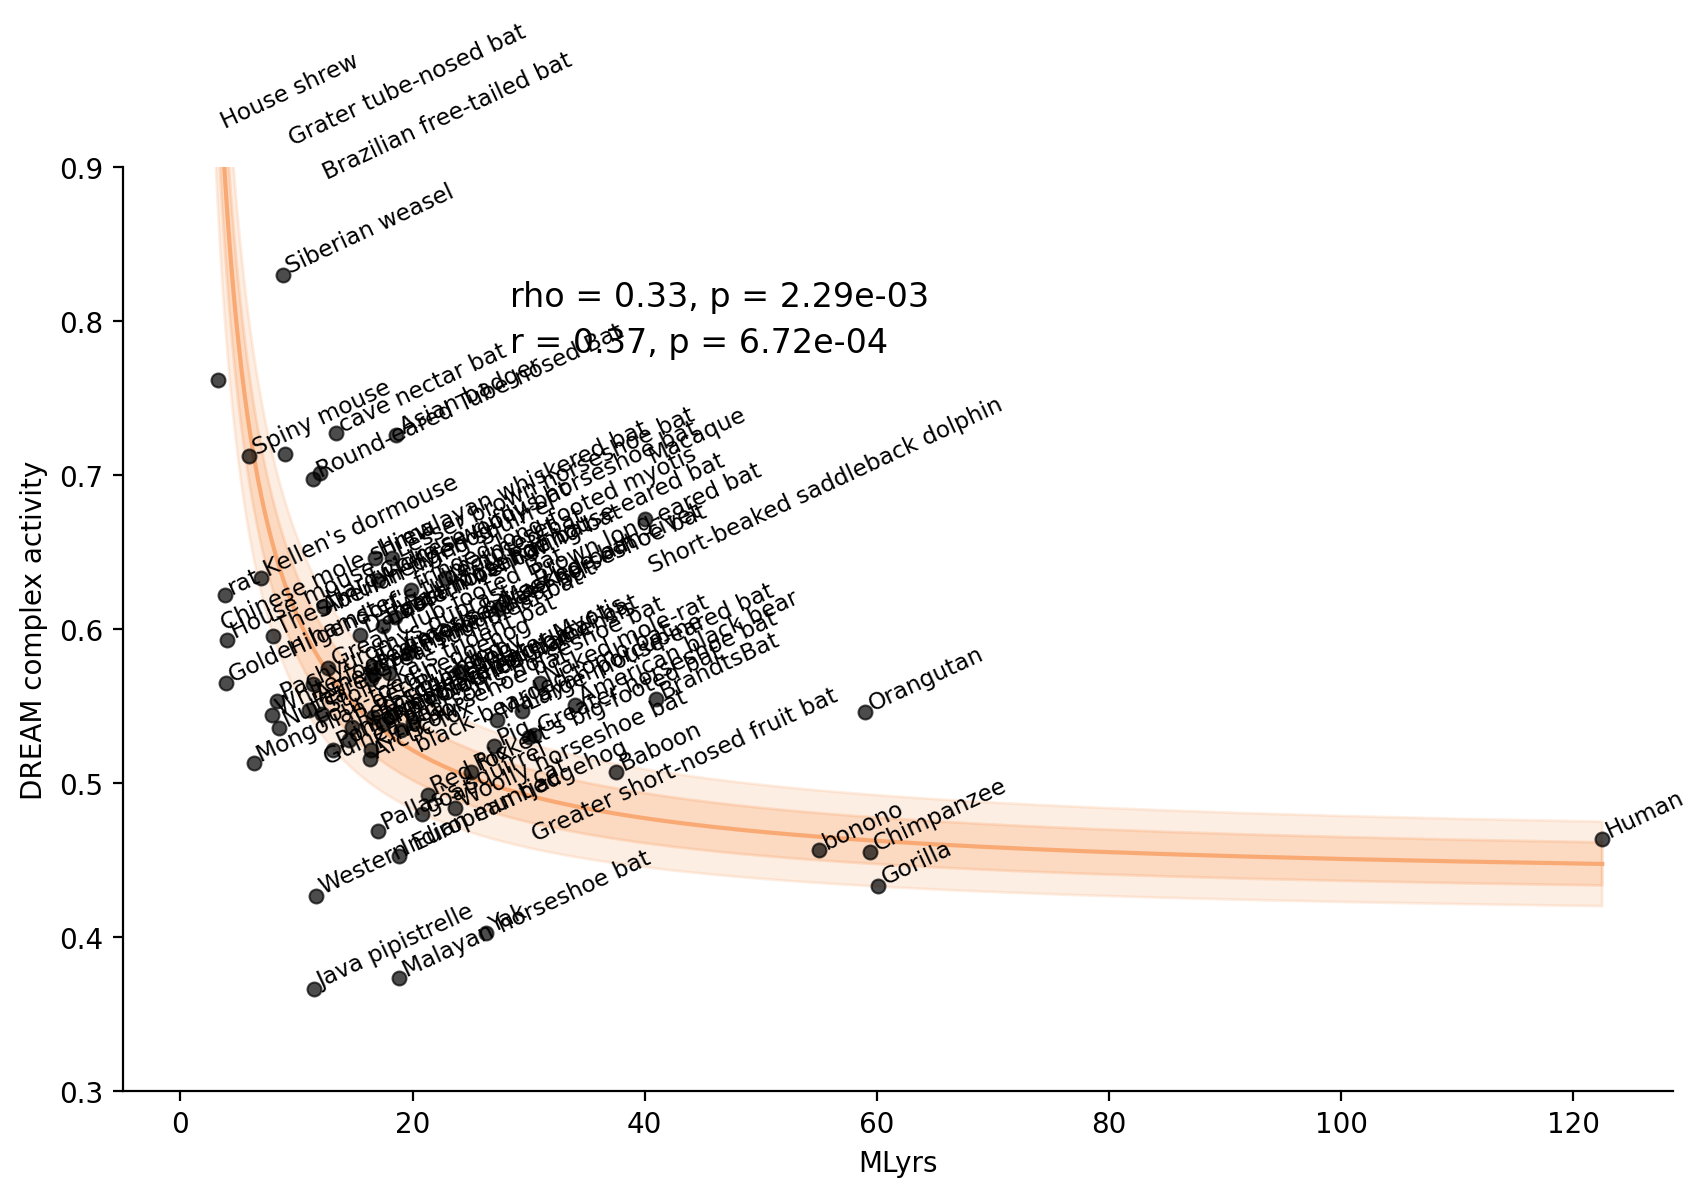

In [13]:
fig, axes = plt.subplots(1,1, figsize=(10, 6))
x = "MLyrs" #lifespan_80percentile_HMD_species360"#
y = "DREAM_normalized_enrichment_score_resid"
tissue = 'Liver'
use_organ = True
# get rid of orders with only 1 species
num_species_in_order = liu_2023.dream_expression.query("Organ == @tissue").groupby("Order")['Common_name'].nunique().sort_values()
orders_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species with less than 3 samples
num_samples_per_species = liu_2023.dream_expression.query("Organ == @tissue")['Common_name'].value_counts()
species_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_to_use
species_to_use = species_to_use[species_to_use != 'BowheadWhale']

mean_x = liu_2023.dream_expression.query("Organ == @tissue and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").groupby(["Common_name"])[x].mean()
mean_y = liu_2023.dream_expression.query("Organ == @tissue and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").groupby(["Common_name"])[y].mean()
    
# combine
mean_df = pd.concat([mean_x, mean_y], axis=1)
mean_df.dropna(inplace=True, subset=[x, y])
mean_df.reset_index(inplace=True, drop=False)

def fxn_to_apply(name:str, values:np.array):
    if name=='inverse':
        return 1/values
    elif name=='log':
        return np.log10(values)
    

for i,organ in enumerate([tissue]):
    x_inverse = fxn_to_apply('inverse', liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)")[x].values)
    y_for_reg = liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)")[y]
    # mean values to not overweight species with more samples
    x_inverse_for_corr = fxn_to_apply('inverse', liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").groupby("Common_name")[x].mean().values)
    y_for_corr = liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").groupby("Common_name")[y].mean()
    # find the expected slope and intercept
    _, _, _, p_value, _ = linregress(
        x_inverse, y_for_reg
        )
    results = regress2(
        x_inverse, y_for_reg, 
        )
    slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
    x_vals = np.linspace(x_inverse.min(), x_inverse.max()+.6, 1000)
    y_vals = slope * x_vals + intercept
    
    axes.plot(1/x_vals, y_vals, color = organ_palette[tissue])
    # set in middle left of this axes
    #_ = axes.text(0.25, 0.80, f"r = {r_value:.2f}, p = {p_value:.2e}", fontsize=12, transform=axes.transAxes)
    # add a confidence interval, using std
    lower_bound = (slope - std_err) * x_vals + (intercept - std_intercept)
    upper_bound = (slope + std_err) * x_vals + (intercept + std_intercept)
    axes.fill_between(1/x_vals, lower_bound, upper_bound, alpha=0.3, color=organ_palette[tissue])
    # and 95% confidence
    lower_bound = (slope - 1.96*std_err) * x_vals + (intercept - 1.96*std_intercept)
    upper_bound = (slope + 1.96*std_err) * x_vals + (intercept + 1.96*std_intercept)
    axes.fill_between(1/x_vals, lower_bound, upper_bound, alpha=0.2, color=organ_palette[tissue])

"""sns.scatterplot(
    data = liu_2023.dream_expression.query("Organ == @organ"), x = x, y = y, 
    s= 50, alpha = 0.7, c = my_categorical_palette[-2],
    legend =True, ax = axes,
)"""

sns.pointplot(
    data = liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)"),
    x = x, y = y, 
    alpha = 0.7,
    legend =True, ax = axes, linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1,color='black',errorbar=None
)


# add spearman correlation to plot upper right
spearman_r, spearman_p = spearmanr(x_inverse_for_corr, y_for_corr)
_ = axes.text(0.25, 0.85, f"rho = {spearman_r:.2f}, p = {spearman_p:.2e}", fontsize=12, transform=axes.transAxes)
# add pearson correlation
pearson_r, pearson_p = pearsonr(x_inverse_for_corr, y_for_corr)
_ = axes.text(0.25, 0.80, f"r = {pearson_r:.2f}, p = {pearson_p:.2e}", fontsize=12, transform=axes.transAxes)
# move legend off plot and remove borden and shading
sns.despine()
"""axes.set_xscale('log')
axes.set_yscale('log')"""

plt.ylim(0.3,  0.9)
# remove 
axes.set_ylabel("DREAM complex activity")

# plot common name next to each point
for line in range(0, mean_df.shape[0]):
    # move farther from point
    """if mean_df['Common_name'][line] == 'House shrew':
        axes.text(mean_df[x][line]+.01, mean_df[y][line]+.001, mean_df['Common_name'][line], horizontalalignment='left', size='small', color='black',  rotation=25)"""
    axes.text(mean_df[x][line]+.01, mean_df[y][line]+.001, mean_df['Common_name'][line], horizontalalignment='left', size='small', color='black',  rotation=25)
    
#plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/liver_all_species_negExp.svg", dpi = 300)

Text(0, 0.5, 'DREAM complex activity')

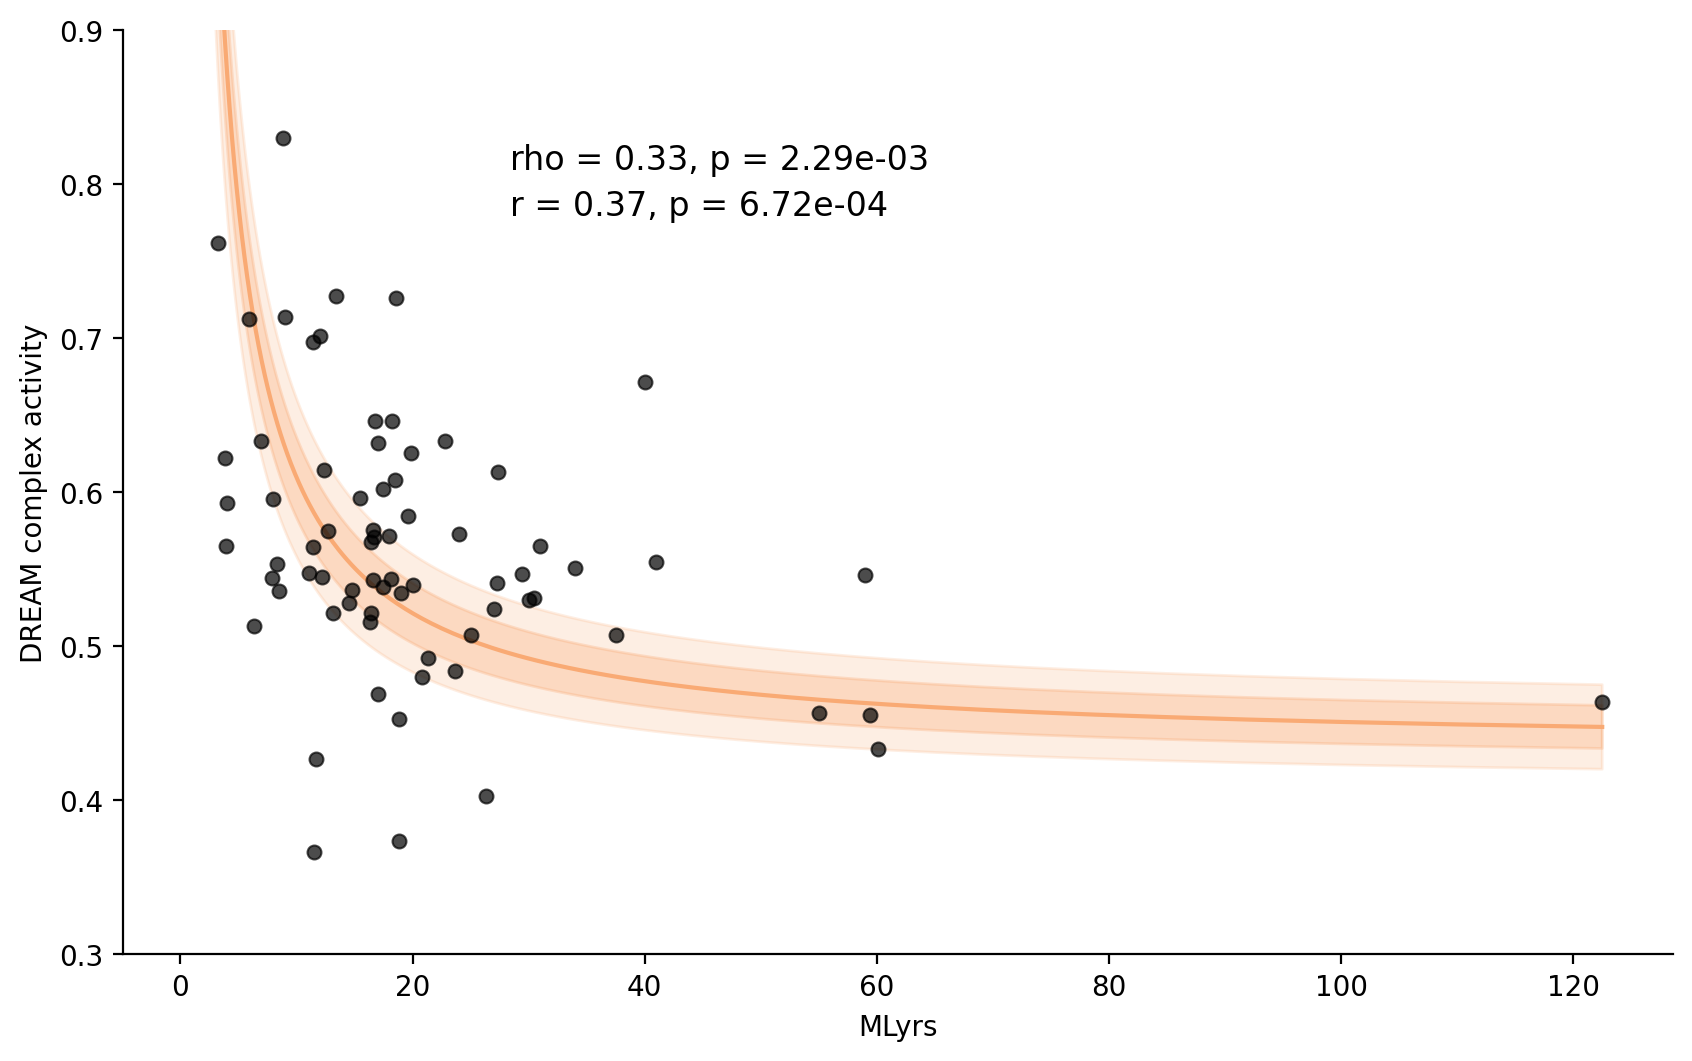

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(10, 6))
x = "MLyrs" #lifespan_80percentile_HMD_species360"#
y = "DREAM_normalized_enrichment_score_resid"
tissue = 'Liver'
use_organ = True
# get rid of orders with only 1 species
num_species_in_order = liu_2023.dream_expression.query("Organ == @tissue").groupby("Order")['Common_name'].nunique().sort_values()
orders_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species with less than 3 samples
num_samples_per_species = liu_2023.dream_expression.query("Organ == @tissue")['Common_name'].value_counts()
species_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_to_use
species_to_use = species_to_use[species_to_use != 'BowheadWhale']

mean_x = liu_2023.dream_expression.query("Organ == @tissue").groupby(["Species"])[x].mean()
mean_y = liu_2023.dream_expression.query("Organ == @tissue").groupby(["Species"])[y].mean()
    
# combine
mean_df = pd.concat([mean_x, mean_y], axis=1)
mean_df.dropna(inplace=True, subset=[x, y])
mean_df.reset_index(inplace=True, drop=False)

def fxn_to_apply(name:str, values:np.array):
    if name=='inverse':
        return 1/values
    elif name=='log':
        return np.log10(values)
    

for i,organ in enumerate([tissue]):
    x_inverse = fxn_to_apply('inverse', liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)")[x].values)
    y_for_reg = liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)")[y]
    # mean values to not overweight species with more samples
    x_inverse_for_corr = fxn_to_apply('inverse', liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").groupby("Common_name")[x].mean().values)
    y_for_corr = liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").groupby("Common_name")[y].mean()
    _, _, _, p_value, _ = linregress(
        x_inverse, y_for_reg
        )
    results = regress2(
        x_inverse, y_for_reg, 
        )
    slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
    x_vals = np.linspace(x_inverse.min(), x_inverse.max()+.6, 1000)
    y_vals = slope * x_vals + intercept
    
    axes.plot(1/x_vals, y_vals, color = organ_palette[tissue])
    # set in middle left of this axes
    #_ = axes.text(0.25, 0.80, f"r = {r_value:.2f}, p = {p_value:.2e}", fontsize=12, transform=axes.transAxes)
    # add a confidence interval, using std
    lower_bound = (slope - std_err) * x_vals + (intercept - std_intercept)
    upper_bound = (slope + std_err) * x_vals + (intercept + std_intercept)
    axes.fill_between(1/x_vals, lower_bound, upper_bound, alpha=0.3, color=organ_palette[tissue])
    # and 95% confidence
    lower_bound = (slope - 1.96*std_err) * x_vals + (intercept - 1.96*std_intercept)
    upper_bound = (slope + 1.96*std_err) * x_vals + (intercept + 1.96*std_intercept)
    axes.fill_between(1/x_vals, lower_bound, upper_bound, alpha=0.2, color=organ_palette[tissue])

"""sns.scatterplot(
    data = liu_2023.dream_expression.query("Organ == @organ"), x = x, y = y, 
    s= 50, alpha = 0.7, c = my_categorical_palette[-2],
    legend =True, ax = axes,
)"""

sns.pointplot(
    data = liu_2023.dream_expression.query("Organ == @organ and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)"),
    x = x, y = y, 
    alpha = 0.7,
    legend =True, ax = axes, linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1,color='black',errorbar=None
)
# add spearman correlation to plot upper right
spearman_r, spearman_p = spearmanr(x_inverse_for_corr, y_for_corr)
_ = axes.text(0.25, 0.85, f"rho = {spearman_r:.2f}, p = {spearman_p:.2e}", fontsize=12, transform=axes.transAxes)
pearson_r, pearson_p = pearsonr(x_inverse_for_corr, y_for_corr)
_ = axes.text(0.25, 0.80, f"r = {pearson_r:.2f}, p = {pearson_p:.2e}", fontsize=12, transform=axes.transAxes)
# move legend off plot and remove borden and shading
sns.despine()
"""axes.set_xscale('log')
axes.set_yscale('log')"""

plt.ylim(0.3,  0.9)
# remove 
axes.set_ylabel("DREAM complex activity")
plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/liver_all_species_negExp.svg", dpi = 300)

In [6]:
print(f"Inverse equation: DREAM = {slope:.3f} * (1/MLyrs) + {intercept:.3f}")
print(f"MLyrs equation: MLyres = 1 / ((DREAM - {intercept:.3f}) / {slope:.3f})")
print(f"R-squared: {spearman_r:.3f}")

Inverse equation: DREAM = 1.765 * (1/MLyrs) + 0.433
MLyrs equation: MLyres = 1 / ((DREAM - 0.433) / 1.765)
R-squared: 0.330


In [28]:
dream_change = 0.1  # or whatever change you want to analyze
baseline_dream = 0.9  # or whatever baseline you want to use
pct_change = (1.765/(baseline_dream + dream_change - 0.433) - 1.765/(baseline_dream - 0.433)) / (1.765/(baseline_dream - 0.433)) * 100
print(f"Percent change: {pct_change:.3f}%")
### Barplots

Percent change: -17.637%


In [17]:
df = pd.DataFrame({
    'DREAM':y_for_corr,
    'MLyrs':x
    })


In [22]:
df['DREAM'].std()

np.float64(0.10242739421357523)

### Barplots

/tmp/ipykernel_2580077/2588073383.py:23: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  sns.barplot(data = liu_2023.dream_expression.query("Common_name in @species_to_use and Organ == 'Liver' and Order in @orders_to_use"), y = 'Common_name', x = 'DREAM_normalized_enrichment_score_resid',  hue = 'Order', palette = 'Oranges_r',
/tmp/ipykernel_2580077/2588073383.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  sns.barplot(data = liu_2023.dream_expression.query("Common_name in @species_to_use and Order in @orders_to_use"), y = 'Common_name', x = 'AW/g_log', hue = 'Order', palette = 'Blues_r',hue_order = across_order_order,
/tmp/ipykernel_2580077/2588073383.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes[0].set_yti

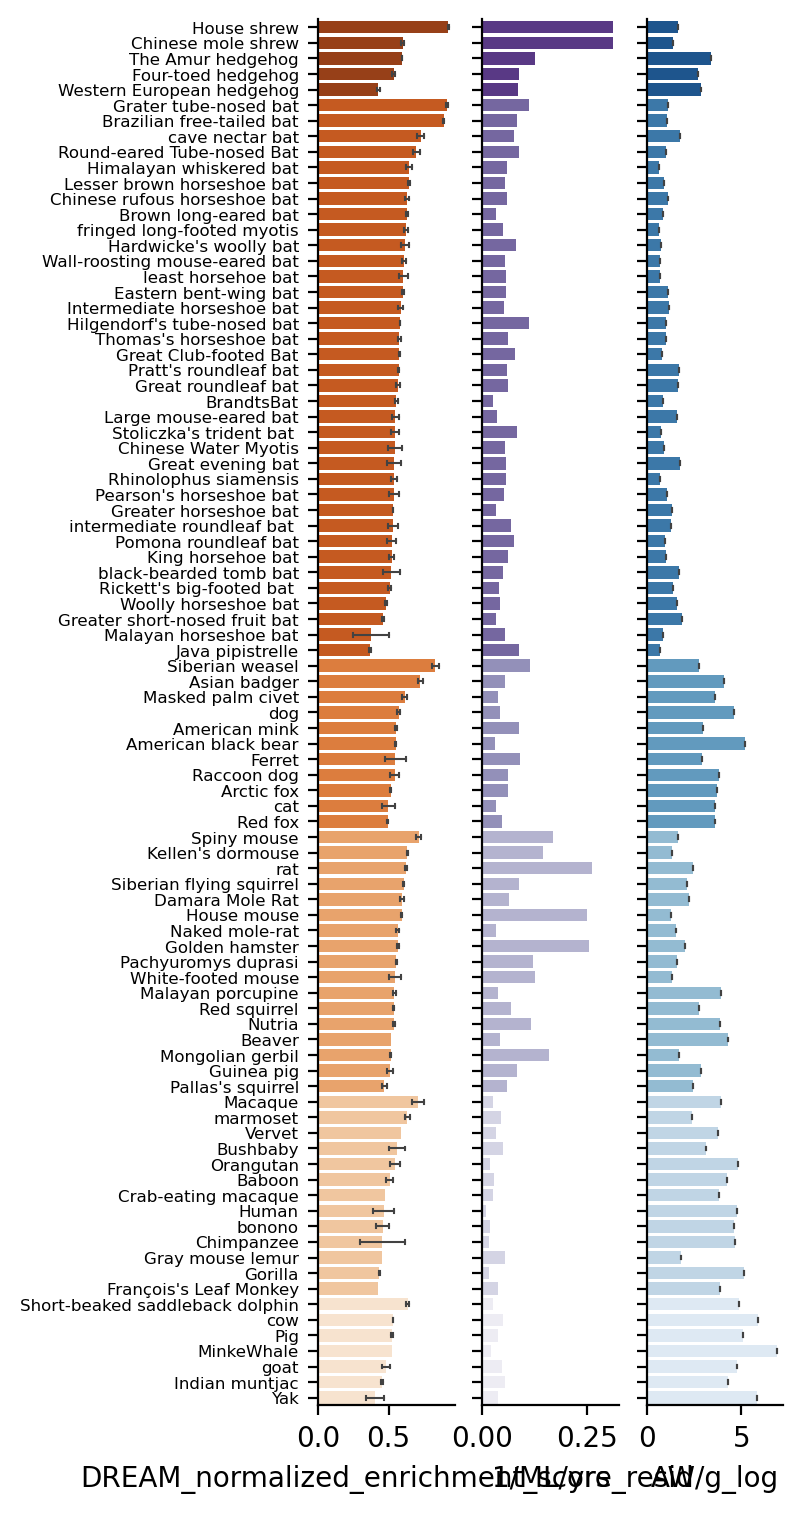

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(3,9), sharey=True)
x = "ML/yrs" #lifespan_80percentile_HMD_species360"#
use_organ = True
# get rid of orders with only 1 species
num_species_in_order = liu_2023.dream_expression.groupby("Order")['Common_name'].nunique().sort_values()
orders_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species with less than 3 samples
num_samples_per_species = liu_2023.dream_expression['Common_name'].value_counts()
species_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_to_use
species_to_use = species_to_use[species_to_use != 'BowheadWhale']
# order by DREAM_normalized_enrichment_score_resid, in liver, within each Order
within_order_order = {}
for order in  liu_2023.dream_expression.query("Common_name in @species_to_use and Order in @orders_to_use")['Order'].unique():
    this_order_species = liu_2023.dream_expression.query("Order == @order and Common_name in @species_to_use and Organ == 'Liver'").groupby("Common_name")['DREAM_normalized_enrichment_score_resid'].mean().sort_values(ascending = False).index
    within_order_order[order] = this_order_species
# across Order order 
across_order_order = liu_2023.dream_expression.query("Common_name in @species_to_use and Organ == 'Liver' and Order in @orders_to_use").groupby("Order")['DREAM_normalized_enrichment_score_resid'].mean().sort_values( ascending = False).index
# concatenate within_order_order based on across_order_order
species_order = []
for order in across_order_order:
    species_order.extend(within_order_order[order])
sns.barplot(data = liu_2023.dream_expression.query("Common_name in @species_to_use and Organ == 'Liver' and Order in @orders_to_use"), y = 'Common_name', x = 'DREAM_normalized_enrichment_score_resid',  hue = 'Order', palette = 'Oranges_r',
        hue_order = across_order_order, orient = 'h', ax = axes[0], order = species_order, errorbar = 'se', errwidth=.75, capsize=0.25, legend = False)
sns.barplot(data = liu_2023.dream_expression.query("Common_name in @species_to_use and Order in @orders_to_use"), y = 'Common_name', x = '1/ML/yrs', hue = 'Order', palette = 'Purples_r',hue_order = across_order_order,
            orient = 'h', ax = axes[1], order = species_order, legend = False)
liu_2023.dream_expression['AW/g_log'] = np.log10(liu_2023.dream_expression['AW/g'])
sns.barplot(data = liu_2023.dream_expression.query("Common_name in @species_to_use and Order in @orders_to_use"), y = 'Common_name', x = 'AW/g_log', hue = 'Order', palette = 'Blues_r',hue_order = across_order_order,
            orient = 'h', ax = axes[2], order = species_order, errorbar = 'se', errwidth=.75, capsize=0.25, legend = False)
# angle y tick labels, make font arial
_ = axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=6)
axes[0].set_ylabel('')
sns.despine()
plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/across_species_bars.svg", dpi = 300)

### Random background

In [18]:
target_col = '1/ML/yrs'
random_background.groupby(["Species", "Organ"])[['DREAM_normalized_enrichment_score_resid', target_col]].mean().reset_index().groupby("Organ")[['DREAM_normalized_enrichment_score_resid', '1/ML/yrs']].corr(method = 'spearman').dropna().iloc[::2][target_col].reset_index()
#random_background.groupby("Organ")[['DREAM_normalized_enrichment_score_resid', '1/ML/yrs']].corr(method = 'spearman')

,Organ,level_1,1/ML/yrs
0,Brain,DREAM_normalized_enrichment_score_resid,0.141582
1,Kidney,DREAM_normalized_enrichment_score_resid,0.153978
2,Liver,DREAM_normalized_enrichment_score_resid,0.327683


In [31]:
def get_corr_across_all_species(
    type: str,
    random_background: pd.DataFrame,
    leave_out_species: str, 
    target_col: str = '1/ML/yrs',
    average_within_species: bool = False
    ):
    # remove the leave on out 
    random_background.query("Species != @leave_out_species", inplace=True)
    
    if type == 'pearson':
        rand_cols = random_background.columns[random_background.columns.str.contains('random')]
        all_ord_corr_df = random_background.groupby(["Organ"])[rand_cols].corrwith(random_background[target_col],method = 'pearson')
        all_ord_corr_df.dropna(inplace=True)
        # stack so that long format
        all_ord_corr_df = all_ord_corr_df.stack().reset_index().rename(columns = {0:'Pearson r'})
        all_ord_corr_df['Gene set'] = 'Random'
        if average_within_species:
            dream_corrs = random_background.groupby(["Species", "Organ"])[['DREAM_normalized_enrichment_score_resid', target_col]].mean().reset_index().groupby("Organ")[['DREAM_normalized_enrichment_score_resid', target_col]].corr(method = 'pearson').dropna().iloc[::2][target_col].reset_index()
        else:
            dream_corrs = random_background.groupby(["Organ"])[['DREAM_normalized_enrichment_score_resid', target_col]].corr(method = 'pearson').dropna().iloc[::2][target_col].reset_index()
        dream_corrs['Gene set'] = 'DREAM-regulated genes'
        dream_corrs.rename(columns = {target_col:'Pearson r'}, inplace=True)
        # combine
        all_ord_corr_df = pd.concat([all_ord_corr_df, dream_corrs], axis = 0)
    elif type == 'spearman':
        rand_cols = random_background.columns[random_background.columns.str.contains('random')]
        spearman_corr_df = random_background.groupby(["Organ"])[rand_cols].corrwith(random_background[target_col], method = 'spearman')
        spearman_corr_df.dropna(inplace=True)
        # stack so that long format
        spearman_corr_df = spearman_corr_df.stack().reset_index().rename(columns = {0:'Spearman rho'})
        spearman_corr_df['Gene set'] = 'Random'
        if average_within_species:
            dream_corrs = random_background.groupby(["Species", "Organ"])[['DREAM_normalized_enrichment_score_resid', target_col]].mean().reset_index().groupby("Organ")[['DREAM_normalized_enrichment_score_resid', target_col]].corr(method = 'spearman').dropna().iloc[::2][target_col].reset_index()
        else:
            dream_corrs = random_background.groupby(["Organ"])[['DREAM_normalized_enrichment_score_resid', target_col]].corr(method = 'spearman').dropna().iloc[::2][target_col].reset_index()
        dream_corrs['Gene set'] = 'DREAM-regulated genes'
        dream_corrs.rename(columns = {target_col:'Spearman rho'}, inplace=True)
        # combine
        all_ord_corr_df = pd.concat([spearman_corr_df, dream_corrs], axis = 0)
    return all_ord_corr_df

def get_ssgsea(
    gene_set: list, 
    expr_object: ExpressionDataset,
    regress: bool,
    ssgsea : bool
    ):
    genes_w_expr = [col for col in expr_object.expression_df.columns if col not in expr_object.meta_cols]
    gene_set_w_expr = list(set(gene_set).intersection(genes_w_expr))
    # get the mean expression of these genes across all cells
    if ssgsea == False:
        expr_object.expression_df['expr'] = expr_object.expression_df[gene_set_w_expr].mean(axis=1)
    else:
        # get dream gene to check for enrichment in expression
        gene_set_dict = {
            'gene_set': gene_set_w_expr
            }        
        # get number of system threads
        #threads = os.cpu_count()
        ssgsea = gseapy.ssgsea(
            data=expr_object.expression_df[genes_w_expr].T, # get a df version of the expr
            gene_sets=gene_set_dict,
            outdir=None, no_plot=True, verbose = False,
            #threads = threads
            )
        results_df = ssgsea.res2d
        results_df.set_index('Name', inplace=True)
        results_df.drop(columns = ['Term','ES'], inplace=True)
        results_df.rename(
            columns = {'NES':'expr'},
            inplace=True
            )
        # convert cols to float
        results_df = results_df.astype(float)
        # merge with expr_object
        expr_object.expression_df['expr'] = results_df['expr']
    if regress:
        expr_ols = smf.ols(
            formula='expr ~ total_seq_depth * n_genes_expressed', data=expr_object.expression_df
            ).fit()
        expr_object.expression_df['expr_resid'] = expr_ols.resid
        expr_object.expression_df['expr_resid_scaled'] = expr_object.expression_df['expr_resid'] - min(expr_object.expression_df['expr_resid'])
        to_return = expr_object.expression_df['expr_resid_scaled'].copy(deep=True)
        # drop
        expr_object.expression_df.drop(['expr_resid', 'expr_resid_scaled'], axis=1, inplace=True)
        return to_return
    else:
        to_return = expr_object.expression_df['expr'].copy(deep=True)
        # drop
        expr_object.expression_df.drop('expr', axis=1, inplace=True)
        return to_return

def create_random_background(
    num_iter, 
    expr_object : ExpressionDataset,
    regress : bool = True,
    ssgsea : bool = True,
    choose_from_background = []):
    n_dream_genes_w_expr = 289#len(dream_genes_w_expr) # aka 249
    # randomly choose sets of n_dream_genes_w_expr from facs genes
    random.seed(42)
    
    if choose_from_background == []:
        genes_to_choose_from = [col for col in expr_object.expression_df.columns if col not in expr_object.meta_cols]
    else:
        genes_to_choose_from = set(choose_from_background)
        print(f"using {len(genes_to_choose_from)} provided genes to choose from")
        
    random_expressions = []
    for i in range(num_iter):
        # choose random genes
        random_genes = random.sample(genes_to_choose_from, n_dream_genes_w_expr)
        random_expressions.append(get_ssgsea(random_genes, expr_object, regress, ssgsea))
        if i % 10 == 0:
            print(f"finished {i} of {num_iter}")
        
    random_background_mean_expression_df = pd.concat(random_expressions, axis = 1)
    random_background_mean_expression_df.columns = [f'random_{n}' for n in range(len(random_expressions))]
    # add necessary cols
    random_background_mean_expression_df['Organ'] = expr_object.expression_df['Organ']
    random_background_mean_expression_df['Species'] = expr_object.expression_df['Species']
    random_background_mean_expression_df['Order'] = expr_object.expression_df['Order']
    
    
    random_background_mean_expression_df['total_seq_depth'] = expr_object.expression_df['total_seq_depth']
    random_background_mean_expression_df['n_genes_expressed'] = expr_object.expression_df['n_genes_expressed']
    random_background_mean_expression_df['ML/yrs'] = expr_object.expression_df['ML/yrs']
    random_background_mean_expression_df['1/ML/yrs'] = expr_object.expression_df['1/ML/yrs']
    
    random_background_mean_expression_df['DREAM_normalized_enrichment_score_resid'] = expr_object.dream_expression['DREAM_normalized_enrichment_score_resid']

    return random_background_mean_expression_df

"""random_background = create_random_background(num_iter = 1000, expr_object = liu_2023, regress = True, ssgsea = True)
random_background['1/ML/yrs'] = 1/random_background['ML/yrs']
rand_cols = random_background.columns[random_background.columns.str.contains('random')]
random_background.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_random_background_1000iter_w_regress_and_ssgsea_maxWeightCorrected.parquet")"""

'random_background = create_random_background(num_iter = 1000, expr_object = liu_2023, regress = True, ssgsea = True)\nrandom_background[\'1/ML/yrs\'] = 1/random_background[\'ML/yrs\']\nrand_cols = random_background.columns[random_background.columns.str.contains(\'random\')]\nrandom_background.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_random_background_1000iter_w_regress_and_ssgsea_maxWeightCorrected.parquet")'

##### W/out AW regression

In [8]:
# read 
random_background = pd.read_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_random_background_1000iter_w_regress_and_ssgsea.parquet")
adult_weight_map = liu_2023.dream_expression['AWg']
random_background['AWg'] = random_background.index.map(adult_weight_map)

spearman_all_corr_df = pd.read_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_spearman_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea.parquet")
pearson_all_corr_df = pd.read_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_pearson_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea.parquet")

In [11]:
num_species_in_order = liu_2023.dream_expression.groupby(["Organ", "Order"])['Species'].nunique().sort_values()
orders_organs_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species from an organ if they have less than 3 samples
num_samples_per_species = liu_2023.dream_expression[['Organ', 'Species']].value_counts()
species_organs_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_organs_to_use
species_organs_to_use = species_organs_to_use[species_organs_to_use.get_level_values(1) != 'Balaena_mysticetus']

# subet random_background to only include species-organ pairs that are in species_organs_to_use
random_background.query("Organ in @species_organs_to_use.get_level_values(0) and Species in @species_organs_to_use.get_level_values(1)", inplace=True)

# subset random_background to only include order-organ pairs that are in orders_organs_to_use
random_background.query("Organ in @orders_organs_to_use.get_level_values(0) and Order in @orders_organs_to_use.get_level_values(1)", inplace=True)

In [32]:
# get the LOO pearson correlation
all_corr_dfs = []
for i, species_to_leave_out in enumerate(random_background['Species'].unique()):
    this_corr_df = get_corr_across_all_species(
        type = 'pearson',
        random_background = random_background.copy(deep=True),
        leave_out_species = species_to_leave_out,
        average_within_species = True
    )
    this_corr_df['left_out'] = species_to_leave_out
    all_corr_dfs.append(this_corr_df)
    if i % 10 == 0:
        print(f"finished {i} of {len(random_background['Species'].unique())}")
pearson_all_corr_df = pd.concat(all_corr_dfs, axis = 0)
pearson_all_corr_df.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_pearson_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_average_within_species.parquet")

"""# get the LOO spearman correlation
spearman_all_corr_dfs = []
for i, species_to_leave_out in enumerate(random_background['Species'].unique()):
    this_corr_df = get_corr_across_all_species(
        type = 'spearman',
        random_background = random_background.copy(deep=True),
        leave_out_species = species_to_leave_out,
        average_within_species = True
    )
    this_corr_df['left_out'] = species_to_leave_out
    spearman_all_corr_dfs.append(this_corr_df)
    if i % 10 == 0:
        print(f"finished {i} of {len(random_background['Species'].unique())}")
spearman_all_corr_df = pd.concat(spearman_all_corr_dfs, axis = 0)
spearman_all_corr_df.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_spearman_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_average_within_species.parquet")"""

finished 0 of 86
finished 10 of 86
finished 20 of 86
finished 30 of 86
finished 40 of 86
finished 50 of 86
finished 60 of 86
finished 70 of 86
finished 80 of 86


'# get the LOO spearman correlation\nspearman_all_corr_dfs = []\nfor i, species_to_leave_out in enumerate(random_background[\'Species\'].unique()):\n    this_corr_df = get_corr_across_all_species(\n        type = \'spearman\',\n        random_background = random_background.copy(deep=True),\n        leave_out_species = species_to_leave_out,\n        average_within_species = True\n    )\n    this_corr_df[\'left_out\'] = species_to_leave_out\n    spearman_all_corr_dfs.append(this_corr_df)\n    if i % 10 == 0:\n        print(f"finished {i} of {len(random_background[\'Species\'].unique())}")\nspearman_all_corr_df = pd.concat(spearman_all_corr_dfs, axis = 0)\nspearman_all_corr_df.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_spearman_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_average_within_species.parquet")'

MannwhitneyuResult(statistic=np.float64(7319240.0), pvalue=np.float64(1.0856712647651685e-55))
MannwhitneyuResult(statistic=np.float64(6015461.0), pvalue=np.float64(8.22644442028088e-24))
MannwhitneyuResult(statistic=np.float64(6299706.0), pvalue=np.float64(1.3909806971677784e-29))
0.32763897942409814
0.003187355087396612
0.14156024613847915
0.006150730275493401
0.15396026232829144
0.0033201443537195733


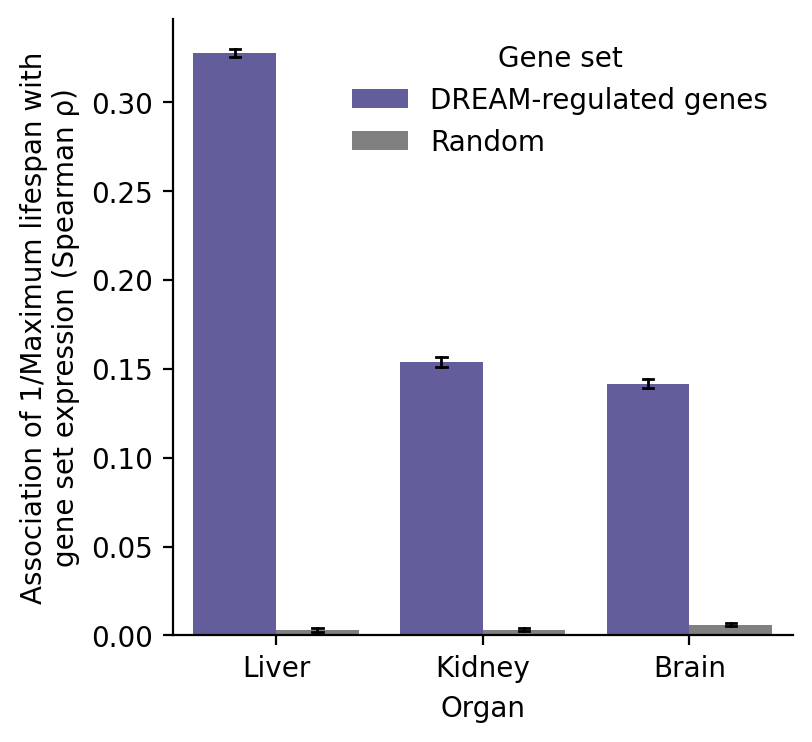

In [34]:
# new
fig, axes = plt.subplots(1,1, figsize=(4, 4))
sns.barplot(
    data = spearman_all_corr_df, y = 'Spearman rho',
    hue = 'Gene set', x = 'Organ',linestyle='none',
    palette = [my_categorical_palette[5], 'grey'],
    ax = axes, hue_order = ['DREAM-regulated genes', 'Random'],
    order = ['Liver', 'Kidney', 'Brain'], err_kws={'linewidth': 1, 'color':'black'}, capsize = 0.1,
    errorbar = ('ci',95),  
    # add border around bars
    )
sns.despine()
axes.set_ylabel("Association of 1/Maximum lifespan with\ngene set expression (Spearman ρ)")
# get rid of border and background
axes.legend(title = "Gene set",shadow = False, fancybox = False, frameon = False)
plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/corr_bars.svg", dpi = 300)

# do a mannwhitney U test between each pair
print(mannwhitneyu(spearman_all_corr_df.query("Organ == 'Liver' and `Gene set` == 'DREAM-regulated genes'")['Spearman rho'],
             spearman_all_corr_df.query("Organ == 'Liver' and `Gene set` == 'Random'")['Spearman rho']))
print(mannwhitneyu(spearman_all_corr_df.query("Organ == 'Brain' and `Gene set` == 'DREAM-regulated genes'")['Spearman rho'],
             spearman_all_corr_df.query("Organ == 'Brain' and `Gene set` == 'Random'")['Spearman rho']))
print(mannwhitneyu(spearman_all_corr_df.query("Organ == 'Kidney' and `Gene set` == 'DREAM-regulated genes'")['Spearman rho'],
             spearman_all_corr_df.query("Organ == 'Kidney' and `Gene set` == 'Random'")['Spearman rho']))

# print mean of each 
print(spearman_all_corr_df.query("Organ == 'Liver' and `Gene set` == 'DREAM-regulated genes'")['Spearman rho'].mean())
print(spearman_all_corr_df.query("Organ == 'Liver' and `Gene set` == 'Random'")['Spearman rho'].mean())
print(spearman_all_corr_df.query("Organ == 'Brain' and `Gene set` == 'DREAM-regulated genes'")['Spearman rho'].mean())
print(spearman_all_corr_df.query("Organ == 'Brain' and `Gene set` == 'Random'")['Spearman rho'].mean())
print(spearman_all_corr_df.query("Organ == 'Kidney' and `Gene set` == 'DREAM-regulated genes'")['Spearman rho'].mean())
print(spearman_all_corr_df.query("Organ == 'Kidney' and `Gene set` == 'Random'")['Spearman rho'].mean())

##### W/ AW regression

In [12]:
# read 
random_background = pd.read_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_random_background_1000iter_w_regress_and_ssgsea.parquet")
adult_weight_map = liu_2023.dream_expression['AW/g']
random_background['AW/g'] = random_background.index.map(adult_weight_map)

spearman_all_corr_df_aw = pd.read_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_spearman_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_AWregressed_organGrouping.parquet")
pearson_all_corr_df_aw = pd.read_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_pearson_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_AWregressed_organGrouping.parquet")

In [38]:


num_species_in_order = liu_2023.dream_expression.groupby(["Organ", "Order"])['Species'].nunique().sort_values()
orders_organs_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species from an organ if they have less than 3 samples
num_samples_per_species = liu_2023.dream_expression[['Organ', 'Species']].value_counts()
species_organs_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_organs_to_use
species_organs_to_use = species_organs_to_use[species_organs_to_use.get_level_values(1) != 'Balaena_mysticetus']

# subet random_background to only include species-organ pairs that are in species_organs_to_use
random_background_subset = random_background.query("Organ in @species_organs_to_use.get_level_values(0) and Species in @species_organs_to_use.get_level_values(1)")

# subset random_background to only include order-organ pairs that are in orders_organs_to_use
random_background_subset.query("Organ in @orders_organs_to_use.get_level_values(0) and Order in @orders_organs_to_use.get_level_values(1)", inplace=True)
random_background_subset_mean = random_background_subset[random_background_subset.columns[random_background_subset.dtypes != 'object']]

# take log of whole df
random_background_subset_mean_log = np.log2(1 + random_background_subset_mean)


random_background_subset_mean_log.reset_index(inplace=True)
# replace / with ''
random_background_subset_mean_log.columns = random_background_subset_mean_log.columns.str.replace('1/', 'oneOver')
random_background_subset_mean_log.columns = random_background_subset_mean_log.columns.str.replace('/', '')
# create organ column
random_background_subset_mean_log.set_index('index' , inplace=True)
random_background_subset_mean_log['Organ'] = random_background_subset_mean_log.index.str.split('.').str[1]


# regress adult weight out of eachr random 
def regress_out_weight(col_name, df):
    # regress out adult weight
    try:
        ols = regress2(
            df['AWg'], df[col_name]
            )
        return df[col_name] - ols['predict']
        """model = smf.ols(
            formula=f"{col_name} ~ AWg * Organ", data=df
            ).fit()
        return model.resid"""
    except:
        # return nan
        return [np.nan] * len(df[col_name])
    
"""random_background_subset_mean_log_regressed = random_background_subset_mean_log.iloc[:, :-1].apply(
    lambda x: regress_out_weight(x.name, random_background_subset_mean_log), axis = 0
    )
# add back index
random_background_subset_mean_log_regressed = pd.concat([random_background_subset_mean_log.iloc[:, -1], random_background_subset_mean_log_regressed], axis = 1)
#random_background_subset_mean_log_regressed.dropna(inplace=True, axis = 1)"""

# Group by Organ and apply regress_out_weight to each organ df
random_background_subset_mean_log_regressed_grouped = random_background_subset_mean_log.groupby('Organ').apply(
    lambda x: x.iloc[:, 1:].apply(lambda col: regress_out_weight(col.name, x), axis=0)
)
random_background_subset_mean_log_regressed = random_background_subset_mean_log_regressed_grouped.drop('Organ', axis = 1).reset_index().set_index('index')

/tmp/ipykernel_2969725/1539782402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_background_subset.query("Organ in @orders_organs_to_use.get_level_values(0) and Order in @orders_organs_to_use.get_level_values(1)", inplace=True)
/tmp/ipykernel_2969725/1539782402.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_background_subset_mean_log_regressed_grouped = random_background_subset_mean_log.groupby('Organ').apply(


In [81]:
random_background_subset_mean_log['Species'] = random_background_subset_mean_log.index.str.split('.').str[0]
# get the LOO pearson correlation 
all_corr_dfs = []
for i, species_to_leave_out in enumerate(random_background_subset_mean_log['Species'].unique()):
    this_corr_df = get_corr_across_all_species(
        type = 'pearson',
        random_background = random_background_subset_mean_log.copy(deep=True),
        leave_out_species = species_to_leave_out,
        target_col = 'MLyrs'
    )
    this_corr_df['left_out'] = species_to_leave_out
    all_corr_dfs.append(this_corr_df)
    if i % 10 == 0:
        print(f"finished {i} of {len(random_background_subset_mean_log['Species'].unique())}")
pearson_all_corr_df_aw = pd.concat(all_corr_dfs, axis = 0)
pearson_all_corr_df_aw.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_pearson_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_log2_noAWregressed_organGrouping.parquet")

# get the LOO spearman correlation
spearman_all_corr_dfs = []
for i, species_to_leave_out in enumerate(random_background_subset_mean_log_regressed['Species'].unique()):
    this_corr_df = get_corr_across_all_species(
        type = 'spearman',
        random_background = random_background_subset_mean_log_regressed.copy(deep=True),
        leave_out_species = species_to_leave_out,
        target_col = 'MLyrs'
    )
    this_corr_df['left_out'] = species_to_leave_out
    spearman_all_corr_dfs.append(this_corr_df)
    if i % 10 == 0:
        print(f"finished {i} of {len(random_background_subset_mean_log_regressed['Species'].unique())}")
spearman_all_corr_df_aw = pd.concat(spearman_all_corr_dfs, axis = 0)
spearman_all_corr_df_aw.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_spearman_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_AWregressed_organGrouping.parquet")

finished 0 of 86
finished 10 of 86
finished 20 of 86
finished 30 of 86
finished 40 of 86
finished 50 of 86
finished 60 of 86
finished 70 of 86
finished 80 of 86


'spearman_all_corr_dfs = []\nfor i, species_to_leave_out in enumerate(random_background_subset_mean_log_regressed[\'Species\'].unique()):\n    this_corr_df = get_corr_across_all_species(\n        type = \'spearman\',\n        random_background = random_background_subset_mean_log_regressed.copy(deep=True),\n        leave_out_species = species_to_leave_out,\n        target_col = \'MLyrs\'\n    )\n    this_corr_df[\'left_out\'] = species_to_leave_out\n    spearman_all_corr_dfs.append(this_corr_df)\n    if i % 10 == 0:\n        print(f"finished {i} of {len(random_background_subset_mean_log_regressed[\'Species\'].unique())}")\nspearman_all_corr_df_aw = pd.concat(spearman_all_corr_dfs, axis = 0)\nspearman_all_corr_df_aw.to_parquet("/cellar/users/zkoch/dream/notebooks/assorted_outputs/liu_2023_spearman_bootstrap_all_corr_df_1000iter_w_regress_and_ssgsea_AWregressed_organGrouping.parquet")'

/tmp/ipykernel_2969725/804236611.py:3: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.barplot(


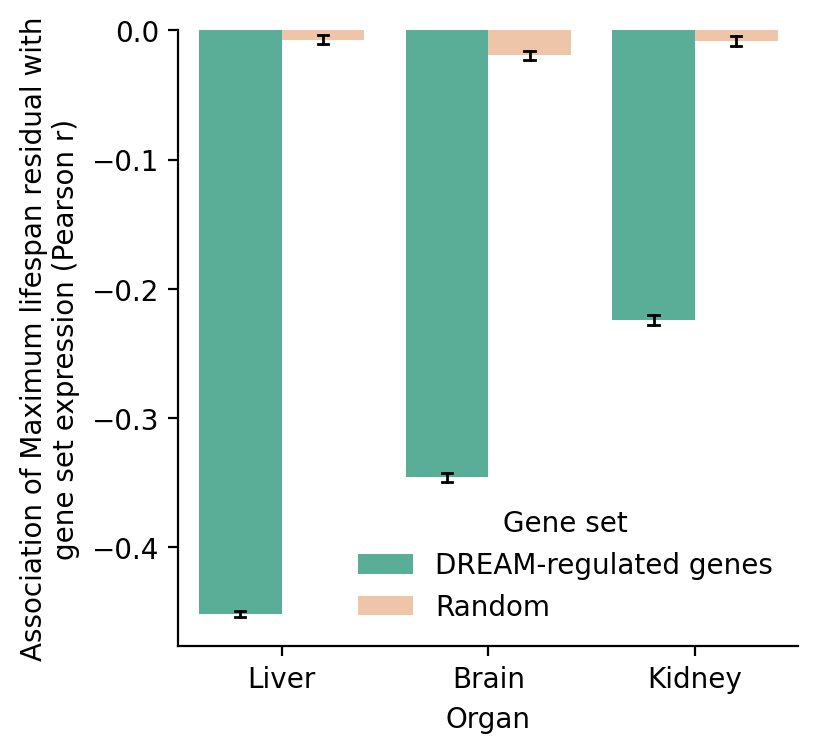

In [46]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))

sns.barplot(
    data = pearson_all_corr_df_aw, y = 'Pearson r',
    hue = 'Gene set', x = 'Organ',linestyle='none',
    palette = my_categorical_palette,
    ax = axes, hue_order = ['DREAM-regulated genes', 'Random'],
    order = ['Liver', 'Brain', 'Kidney'], err_kws={'linewidth': 1, 'color':'black'}, capsize = 0.1,
    errorbar = ('ci',99.99), alpha = 0.7, 
    # add border around bars
    )
sns.despine()
axes.set_ylabel("Association of Maximum lifespan residual with\ngene set expression (Pearson r)")
# get rid of border and background
axes.legend(title = "Gene set", shadow = False, fancybox = False, frameon = False, 
            # move to lower right
            loc = 'lower right')

/tmp/ipykernel_2969725/1346281882.py:3: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.barplot(


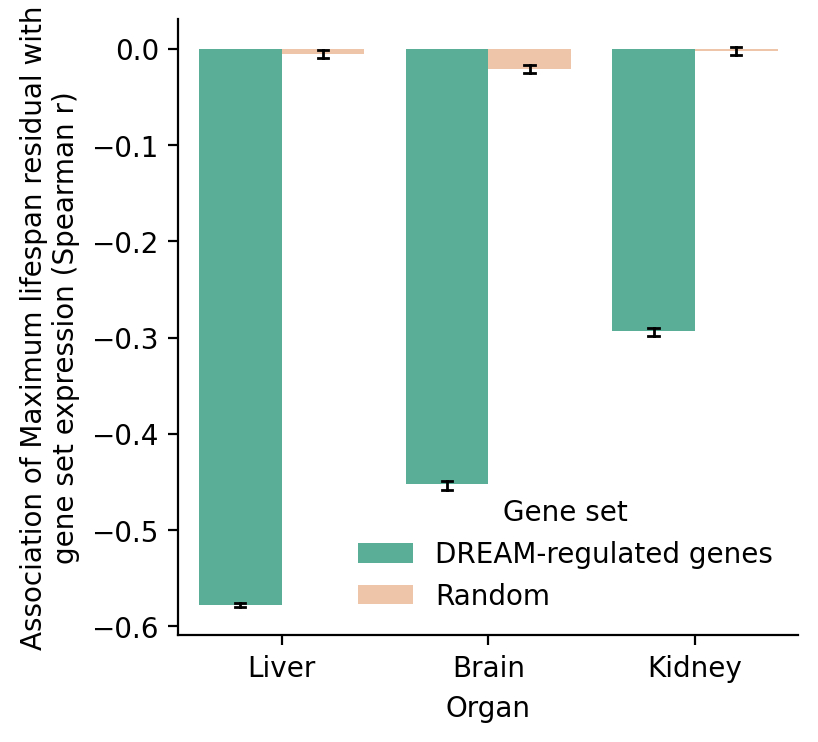

In [45]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))

sns.barplot(
    data = spearman_all_corr_df_aw, y = 'Spearman rho',
    hue = 'Gene set', x = 'Organ',linestyle='none',
    palette = my_categorical_palette,
    ax = axes, hue_order = ['DREAM-regulated genes', 'Random'],
    order = ['Liver', 'Brain', 'Kidney'], err_kws={'linewidth': 1, 'color':'black'}, capsize = 0.1,
    errorbar = ('ci',99.99), alpha = 0.7, 
    # add border around bars
    )
sns.despine()
axes.set_ylabel("Association of Maximum lifespan residual with\ngene set expression (Spearman r)")
# get rid of border and background
axes.legend(title = "Gene set", shadow = False, fancybox = False, frameon = False, 
            # move to lower right
            loc = 'lower right')

### Correlation of DREAM across tissues of species

In [35]:
# get mean DREAM in each tissue for each common name
mean_dream_by_tissue = liu_2023.dream_expression.groupby(['Common_name', 'Organ'])['DREAM_normalized_enrichment_score_resid'].mean()
mean_dream_by_tissue = mean_dream_by_tissue.reset_index(inplace=False, drop=False)
# pivot so that common_name is index, and organ is column
mean_dream_by_tissue = mean_dream_by_tissue.pivot_table(
    index = 'Common_name', columns = 'Organ', values = 'DREAM_normalized_enrichment_score_resid'
    )
mean_dream_by_tissue

Organ,Brain,Kidney,Liver
Common_name,,,
American black bear,0.528557,0.719085,0.551250
American mink,0.629564,0.576387,0.552373
Arctic fox,0.608021,0.561076,0.515613
Asian badger,0.792573,0.659678,0.726044
Aye-aye,NaN,NaN,0.775854
...,...,...,...
marmoset,0.615328,0.552454,0.633175
opossum,0.582783,0.561645,0.566059
platypus,0.335338,0.344091,0.279147


/tmp/ipykernel_4079384/776335546.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_oranges = cm.get_cmap('Reds')
/tmp/ipykernel_4079384/776335546.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_purples = cm.get_cmap('Purples_r')


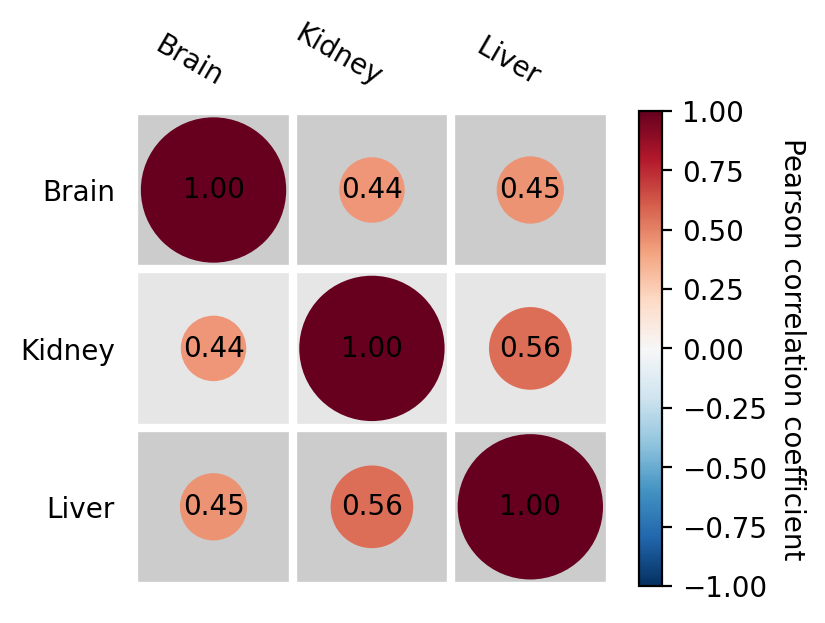

In [40]:
# create a diverging colormap which combines Oranges and Purples

import matplotlib.cm as cm

# Create a colormap combining Oranges and Purples
cmap_oranges = cm.get_cmap('Reds')
cmap_purples = cm.get_cmap('Purples_r')
colors_oranges = cmap_oranges(np.linspace(0, 1, 256))
colors_purples = cmap_purples(np.linspace(0, 1, 256))
colors_combined = np.vstack(( colors_purples, colors_oranges,))
from matplotlib.colors import ListedColormap
cmap_combined = ListedColormap(colors_combined)
# blend the middl

kwargs = {
    'heatmap': {
        'vmin':-1,
        'vmax': 1,
        'cmap': 'RdBu_r',
    },
    'figure': {
        'figsize': (4, 3),
    },
    'cbar_kw':{
        "shrink": 0.01
    }
}
# change label of color bar to Spearman ρ
kwargs['cbar_kw']['label'] = 'Correlation of DREAM activity across\ntissues (Spearman ρ)'
psynlig.plot_correlation_heatmap(mean_dream_by_tissue.dropna(), bubble=True, annotate=True, **kwargs)
plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/dream_corr_across_tissues_bubble_heatmap.svg", dpi = 300)

### Partial correlation of DREAM residual vs. ML residual with respect to body mass

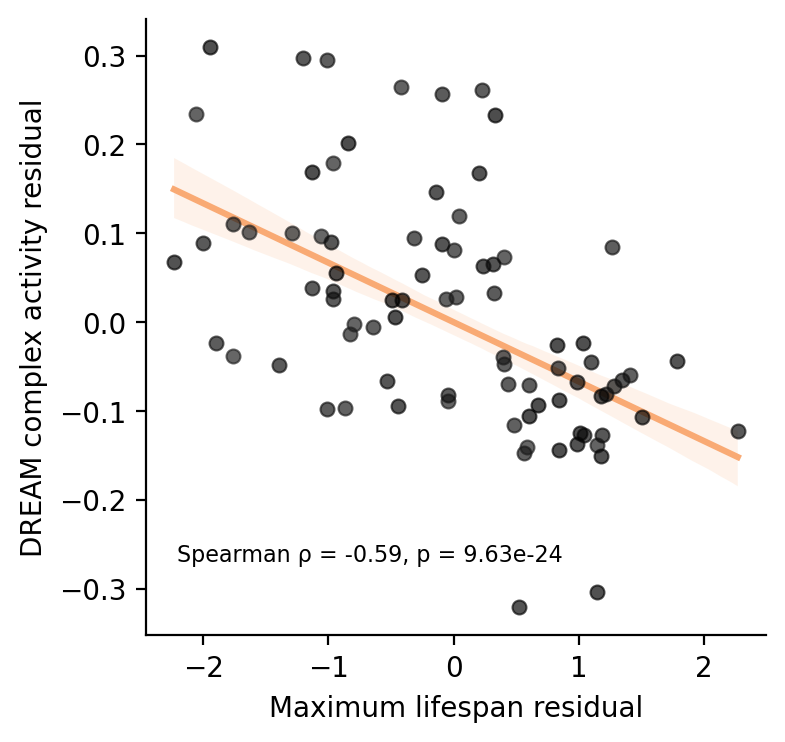

In [62]:
x = "MLyrs" 
y = "DREAM_normalized_enrichment_score_resid"
tissue = 'Liver'
# get rid of orders with only 1 species
num_species_in_order = liu_2023.dream_expression.query("Organ == @tissue").groupby("Order")['Common_name'].nunique().sort_values()
orders_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species with less than 3 samples
num_samples_per_species = liu_2023.dream_expression.query("Organ == @tissue")['Common_name'].value_counts()
species_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_to_use
species_to_use = species_to_use[species_to_use != 'BowheadWhale']
# this tissue df
tissue_df = liu_2023.dream_expression.query("Organ == @tissue and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").copy(deep=True)
tissue_df['log_DREAM_normalized_enrichment_score_resid'] = tissue_df['DREAM_normalized_enrichment_score_resid']
tissue_df['log_MLyrs'] = np.log2(tissue_df['MLyrs'])
tissue_df['log_AWg'] = np.log2(tissue_df['AWg'])
# mask inf wiht nan
tissue_df.replace([np.inf, -np.inf], np.nan, inplace=True)
tissue_df.dropna(subset = ['log_DREAM_normalized_enrichment_score_resid', 'log_AWg'], inplace=True)

# and for non-mean
results = regress2(
    tissue_df['log_AWg'], tissue_df['log_DREAM_normalized_enrichment_score_resid']
    )
tissue_df['log_DREAM_normalized_enrichment_score_resid_WeightResid'] =  tissue_df['log_DREAM_normalized_enrichment_score_resid'] - results['predict']
results = regress2(
    tissue_df['log_AWg'], tissue_df['log_MLyrs']
    )
tissue_df['log_MLyrs_WeightResid'] =  tissue_df['log_MLyrs'] - results['predict']


fig, axes = plt.subplots(1,1, figsize=(4, 4))
sns.regplot(
    data = tissue_df, x = 'log_MLyrs_WeightResid', y = 'log_DREAM_normalized_enrichment_score_resid_WeightResid',
    ax = axes, line_kws={'color':organ_palette[tissue]}, scatter=False
    )
sns.pointplot(
    data = tissue_df, hue = 'Common_name',
    x = 'log_MLyrs_WeightResid', y = 'log_DREAM_normalized_enrichment_score_resid_WeightResid',
    alpha = 0.7,
    linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1, palette='dark:black',errorbar=None, ax = axes, legend=False, 
    # make error bars go horizontal
    orient = 'v'
)
sns.despine()
plt.ylabel("DREAM complex activity residual")
plt.xlabel("Maximum lifespan residual")
rho,p = spearmanr(tissue_df['log_MLyrs_WeightResid'], tissue_df['log_DREAM_normalized_enrichment_score_resid_WeightResid'])
# add rho and p to the plot
plt.text(0.05, 0.15, f"Spearman ρ = {rho:.2f}, p = {p:.2e}", transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/liver_weight_residuals.svg", dpi = 300)

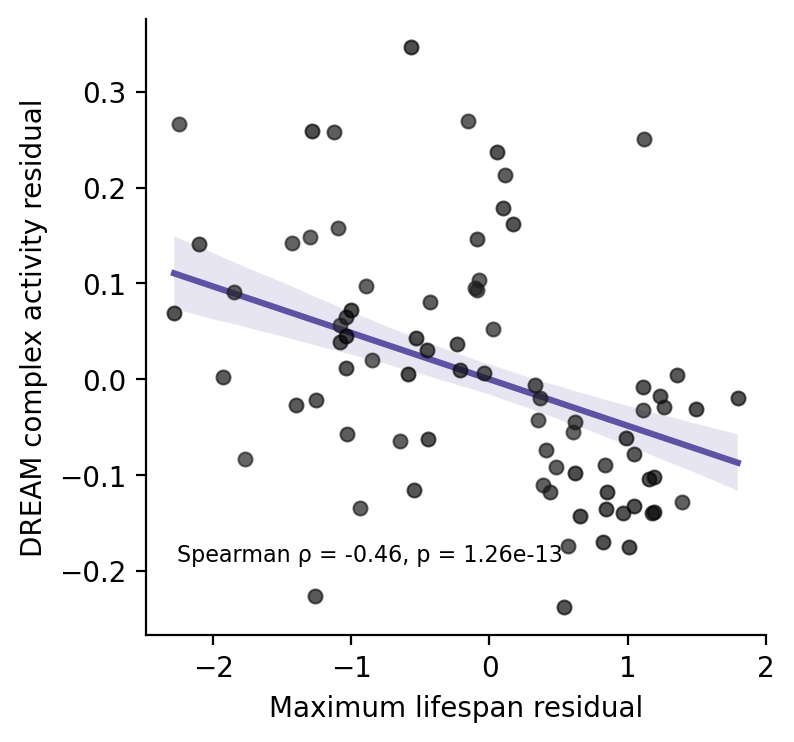

In [61]:
x = "MLyrs" 
y = "DREAM_normalized_enrichment_score_resid"
tissue = 'Brain'
# get rid of orders with only 1 species
num_species_in_order = liu_2023.dream_expression.query("Organ == @tissue").groupby("Order")['Common_name'].nunique().sort_values()
orders_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species with less than 3 samples
num_samples_per_species = liu_2023.dream_expression.query("Organ == @tissue")['Common_name'].value_counts()
species_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_to_use
species_to_use = species_to_use[species_to_use != 'BowheadWhale']
# this tissue df
tissue_df = liu_2023.dream_expression.query("Organ == @tissue and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").copy(deep=True)
tissue_df['log_DREAM_normalized_enrichment_score_resid'] = tissue_df['DREAM_normalized_enrichment_score_resid']
tissue_df['log_MLyrs'] = np.log2(tissue_df['MLyrs'])
tissue_df['log_AWg'] = np.log2(tissue_df['AWg'])
# mask inf wiht nan
tissue_df.replace([np.inf, -np.inf], np.nan, inplace=True)
tissue_df.dropna(subset = ['log_DREAM_normalized_enrichment_score_resid', 'log_AWg'], inplace=True)

# and for non-mean
results = regress2(
    tissue_df['log_AWg'], tissue_df['log_DREAM_normalized_enrichment_score_resid']
    )
tissue_df['log_DREAM_normalized_enrichment_score_resid_WeightResid'] =  tissue_df['log_DREAM_normalized_enrichment_score_resid'] - results['predict']
results = regress2(
    tissue_df['log_AWg'], tissue_df['log_MLyrs']
    )
tissue_df['log_MLyrs_WeightResid'] =  tissue_df['log_MLyrs'] - results['predict']


fig, axes = plt.subplots(1,1, figsize=(4, 4))
sns.regplot(
    data = tissue_df, x = 'log_MLyrs_WeightResid', y = 'log_DREAM_normalized_enrichment_score_resid_WeightResid',
    ax = axes, line_kws={'color':organ_palette[tissue]}, scatter=False
    )
sns.pointplot(
    data = tissue_df, hue = 'Common_name',
    x = 'log_MLyrs_WeightResid', y = 'log_DREAM_normalized_enrichment_score_resid_WeightResid',
    alpha = 0.7,
    linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1, palette='dark:black',errorbar=None, ax = axes, legend=False, 
    # make error bars go horizontal
    orient = 'v'
)
sns.despine()
plt.ylabel("DREAM complex activity residual")
plt.xlabel("Maximum lifespan residual")
rho,p = spearmanr(tissue_df['log_MLyrs_WeightResid'], tissue_df['log_DREAM_normalized_enrichment_score_resid_WeightResid'])
# add rho and p to the plot
plt.text(0.05, 0.15, f"Spearman ρ = {rho:.2f}, p = {p:.2e}", transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/cross_species/brain_weight_residuals.svg", dpi = 300)

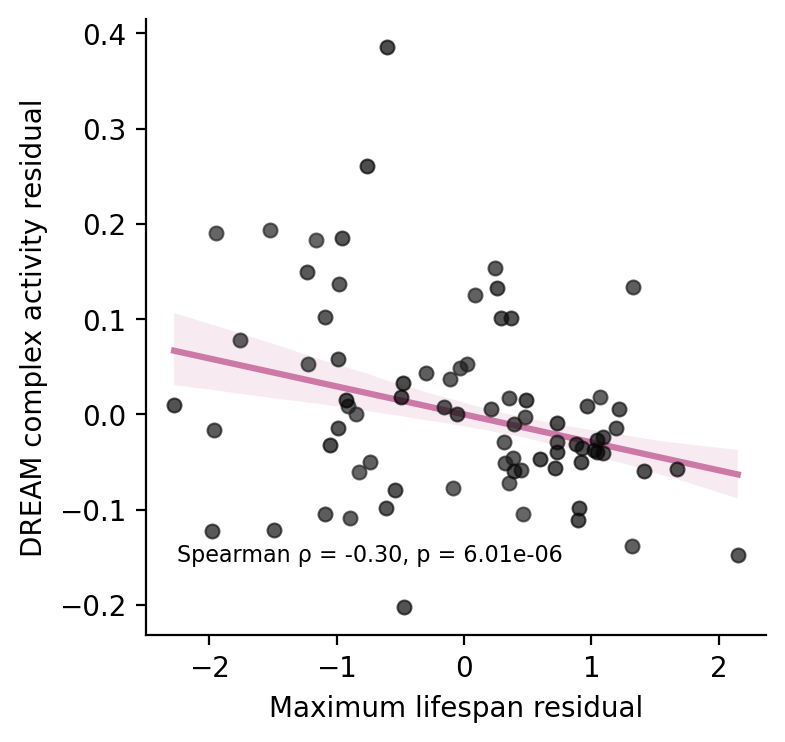

In [60]:
x = "MLyrs" 
y = "DREAM_normalized_enrichment_score_resid"
tissue = 'Kidney'
# get rid of orders with only 1 species
num_species_in_order = liu_2023.dream_expression.query("Organ == @tissue").groupby("Order")['Common_name'].nunique().sort_values()
orders_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species with less than 3 samples
num_samples_per_species = liu_2023.dream_expression.query("Organ == @tissue")['Common_name'].value_counts()
species_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_to_use
species_to_use = species_to_use[species_to_use != 'BowheadWhale']
# this tissue df
tissue_df = liu_2023.dream_expression.query("Organ == @tissue and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)").copy(deep=True)
tissue_df['log_DREAM_normalized_enrichment_score_resid'] = tissue_df['DREAM_normalized_enrichment_score_resid']
tissue_df['log_MLyrs'] = np.log2(tissue_df['MLyrs'])
tissue_df['log_AWg'] = np.log2(tissue_df['AWg'])
# mask inf wiht nan
tissue_df.replace([np.inf, -np.inf], np.nan, inplace=True)
tissue_df.dropna(subset = ['log_DREAM_normalized_enrichment_score_resid', 'log_AWg'], inplace=True)

# and for non-mean
results = regress2(
    tissue_df['log_AWg'], tissue_df['log_DREAM_normalized_enrichment_score_resid']
    )
tissue_df['log_DREAM_normalized_enrichment_score_resid_WeightResid'] =  tissue_df['log_DREAM_normalized_enrichment_score_resid'] - results['predict']
results = regress2(
    tissue_df['log_AWg'], tissue_df['log_MLyrs']
    )
tissue_df['log_MLyrs_WeightResid'] =  tissue_df['log_MLyrs'] - results['predict']


fig, axes = plt.subplots(1,1, figsize=(4, 4))
sns.regplot(
    data = tissue_df, x = 'log_MLyrs_WeightResid', y = 'log_DREAM_normalized_enrichment_score_resid_WeightResid',
    ax = axes, line_kws={'color':organ_palette[tissue]}, scatter=False
    )
sns.pointplot(
    data = tissue_df, hue = 'Common_name',
    x = 'log_MLyrs_WeightResid', y = 'log_DREAM_normalized_enrichment_score_resid_WeightResid',
    alpha = 0.7,
    linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1, palette='dark:black',errorbar=None, ax = axes, legend=False, 
    # make error bars go horizontal
    orient = 'v'
)
sns.despine()
plt.ylabel("DREAM complex activity residual")
plt.xlabel("Maximum lifespan residual")
rho,p = spearmanr(tissue_df['log_MLyrs_WeightResid'], tissue_df['log_DREAM_normalized_enrichment_score_resid_WeightResid'])
# add rho and p to the plot
plt.text(0.05, 0.15, f"Spearman ρ = {rho:.2f}, p = {p:.2e}", transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/cross_species/kidney_weight_residuals.svg", dpi = 300)

### Cagan comparison

In [4]:
cagan_dir = "/cellar/users/zkoch/dream/data/cagan_2022"
cagan_mut_burden= pd.read_excel(os.path.join(cagan_dir, "supp_table3.xlsx"))
species_info = pd.read_excel(os.path.join(cagan_dir, "supp_table1.xlsx"))
# map cagan Species to liu_2023 Species
species_map ={
    'Cat':'cat',
    'Black-and-white colobus': np.nan, # look into this
    'Cow': 'cow',
    'Dog': 'dog',
    'Ferret': 'Ferret',
    'Giraffe': np.nan,
    'Horse': 'Horse',
    'Human': 'Human',
    'Lion': np.nan,
    'Mouse': 'House mouse',
    'Naked mole-rat':'Naked mole-rat',
    'Rabbit': 'rabbit',
    'Rat': 'rat',
    'Ring-tailed lemur':'Ring-tailed lemur',
    'Tiger':np.nan
}
cagan_mut_burden['Common_name'] = cagan_mut_burden['Species'].map(species_map)
liu_2023.dream_expression = liu_2023.dream_expression.merge(cagan_mut_burden[['Common_name', 'Mean mutation rate (SBS/genome/year)']], on = 'Common_name', how = 'left')

##### DREAM vs. mutation rate

/cellar/users/zkoch/miniconda3/envs/dream_proj_env/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


SignificanceResult(statistic=0.46934828346325586, pvalue=0.013516744811935691)
PearsonRResult(statistic=0.4306998422677514, pvalue=0.02491479002094408)


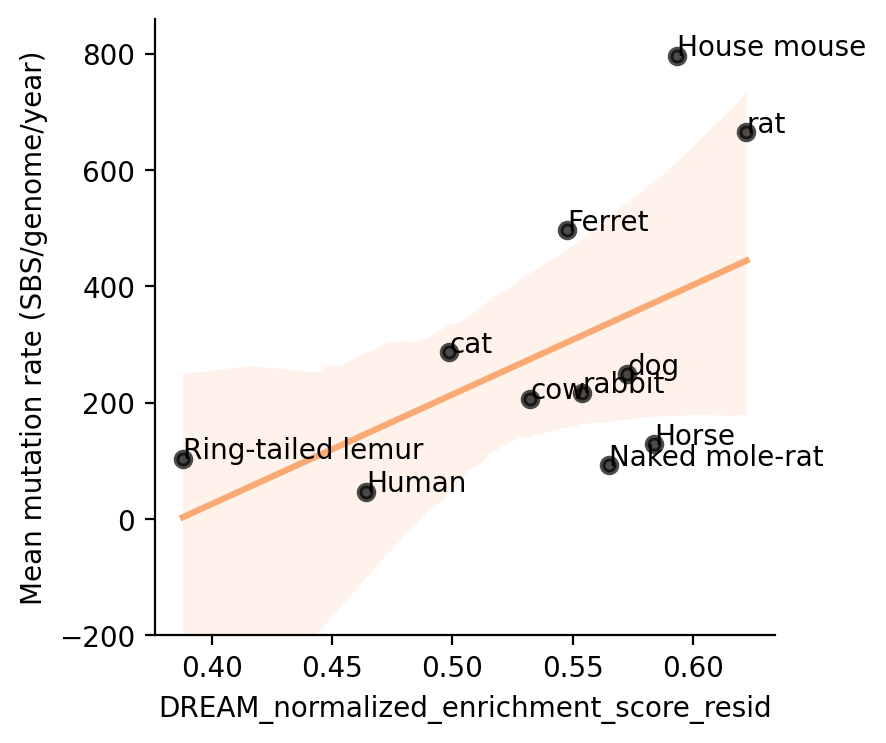

In [505]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))
tissue = 'Liver'
"""sns.regplot(
    liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue"), y ='DREAM_normalized_enrichment_score_resid', x = 'Mean mutation rate (SBS/genome/year)', scatter = False, color = 'blue'
)"""

to_use_df = liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue").copy(deep=True)
# min max scale DREAM_normalized_enrichment_score_resid

"""to_use_df['DREAM_normalized_enrichment_score_resid'] = np.log(to_use_df['DREAM_normalized_enrichment_score_resid'])
to_use_df['Mean mutation rate (SBS/genome/year)'] = np.log(to_use_df['Mean mutation rate (SBS/genome/year)'])"""
sns.pointplot(
    to_use_df, x ='DREAM_normalized_enrichment_score_resid', y = 'Mean mutation rate (SBS/genome/year)', native_scale=True, dodge=True, linestyle='none', color = 'black', alpha = 0.7, errorbar = None, orient = 'h',markersize = 5
)

names_x = to_use_df.groupby(["Common_name"])['DREAM_normalized_enrichment_score_resid'].mean()
names_y = to_use_df.groupby(["Common_name"])['Mean mutation rate (SBS/genome/year)',].mean()
names_df = pd.concat([names_x, names_y], axis=1)
names_df.reset_index(inplace=True, drop=False)
# label each point with common name
for i, row in names_df.iterrows():
    axes.text(row['DREAM_normalized_enrichment_score_resid'], row['Mean mutation rate (SBS/genome/year)'], row['Common_name'], fontsize=10)

sns.regplot(
    names_df, x='DREAM_normalized_enrichment_score_resid', y= 'Mean mutation rate (SBS/genome/year)', scatter = False, color = organ_palette[tissue], ax = axes, robust = True,
)

# do reduced major axis regression
results = regress2(
    to_use_df['DREAM_normalized_enrichment_score_resid'].values, to_use_df['Mean mutation rate (SBS/genome/year)'].values, _need_intercept = True,
    #_method_type_1='robust linear model'
    )
slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
x_vals = np.linspace(to_use_df['DREAM_normalized_enrichment_score_resid'].min(), to_use_df['DREAM_normalized_enrichment_score_resid'].max()+.1, 1000)
y_vals = slope * x_vals + intercept
#axes.plot(x_vals, y_vals, color = 'dodgerblue')



print(spearmanr(to_use_df['DREAM_normalized_enrichment_score_resid'], to_use_df['Mean mutation rate (SBS/genome/year)']))
print(pearsonr(np.log(1+to_use_df['DREAM_normalized_enrichment_score_resid']), np.log(1+to_use_df['Mean mutation rate (SBS/genome/year)'])))
# move legend off plot and remove borden and shading
sns.despine()
plt.ylim(bottom = -200)
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/cross_species/DREAM_vs_mutations_liver.svg", dpi = 300)

SignificanceResult(statistic=0.2848954219426993, pvalue=0.14171234523955775)
PearsonRResult(statistic=-0.015582549971446907, pvalue=0.9372709512407844)


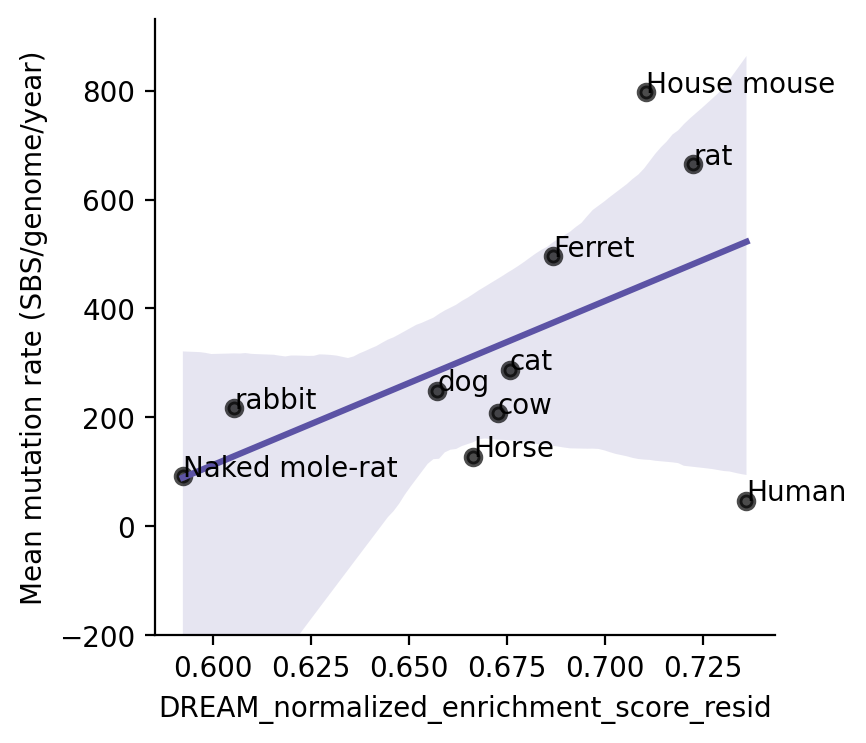

In [506]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))
tissue = 'Brain'
"""sns.regplot(
    liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue"), y ='DREAM_normalized_enrichment_score_resid', x = 'Mean mutation rate (SBS/genome/year)', scatter = False, color = 'blue'
)"""

to_use_df = liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue").copy(deep=True)
# min max scale DREAM_normalized_enrichment_score_resid

"""to_use_df['DREAM_normalized_enrichment_score_resid'] = np.log(to_use_df['DREAM_normalized_enrichment_score_resid'])
to_use_df['Mean mutation rate (SBS/genome/year)'] = np.log(to_use_df['Mean mutation rate (SBS/genome/year)'])"""
sns.pointplot(
    to_use_df, x ='DREAM_normalized_enrichment_score_resid', y = 'Mean mutation rate (SBS/genome/year)', native_scale=True, dodge=True, linestyle='none', color = 'black', alpha = 0.7, errorbar = None, orient = 'h',markersize = 5
)

names_x = to_use_df.groupby(["Common_name"])['DREAM_normalized_enrichment_score_resid'].mean()
names_y = to_use_df.groupby(["Common_name"])['Mean mutation rate (SBS/genome/year)',].mean()
names_df = pd.concat([names_x, names_y], axis=1)
names_df.reset_index(inplace=True, drop=False)
# label each point with common name
for i, row in names_df.iterrows():
    axes.text(row['DREAM_normalized_enrichment_score_resid'], row['Mean mutation rate (SBS/genome/year)'], row['Common_name'], fontsize=10)

sns.regplot(
    names_df, x='DREAM_normalized_enrichment_score_resid', y= 'Mean mutation rate (SBS/genome/year)', scatter = False, color = organ_palette[tissue], ax = axes, robust = True,
)

# do reduced major axis regression
results = regress2(
    to_use_df['DREAM_normalized_enrichment_score_resid'].values, to_use_df['Mean mutation rate (SBS/genome/year)'].values, _need_intercept = True,
    #_method_type_1='robust linear model'
    )
slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
x_vals = np.linspace(to_use_df['DREAM_normalized_enrichment_score_resid'].min(), to_use_df['DREAM_normalized_enrichment_score_resid'].max()+.1, 1000)
y_vals = slope * x_vals + intercept
#axes.plot(x_vals, y_vals, color = 'dodgerblue')



print(spearmanr(to_use_df['DREAM_normalized_enrichment_score_resid'], to_use_df['Mean mutation rate (SBS/genome/year)']))
print(pearsonr(np.log(1+to_use_df['DREAM_normalized_enrichment_score_resid']), np.log(1+to_use_df['Mean mutation rate (SBS/genome/year)'])))
# move legend off plot and remove borden and shading
sns.despine()
plt.ylim(bottom = -200)
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/cross_species/DREAM_vs_mutations_brain.svg", dpi = 300)

SignificanceResult(statistic=0.02576464011752434, pvalue=0.9005760720921119)
PearsonRResult(statistic=0.03168080714978053, pvalue=0.8778979559450532)


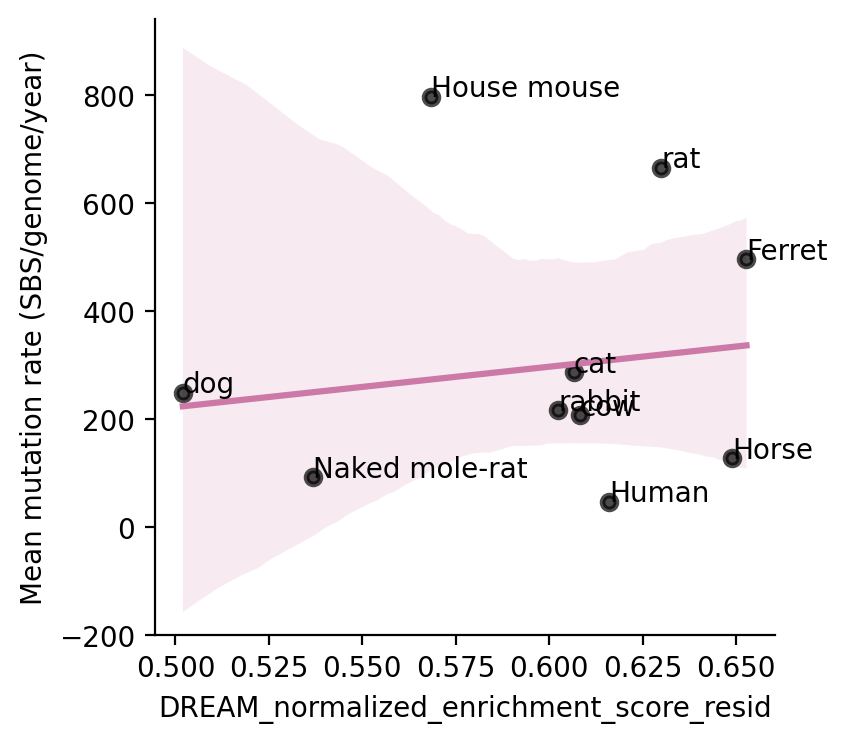

In [507]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))
tissue = 'Kidney'
"""sns.regplot(
    liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue"), y ='DREAM_normalized_enrichment_score_resid', x = 'Mean mutation rate (SBS/genome/year)', scatter = False, color = 'blue'
)"""

to_use_df = liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue").copy(deep=True)
# min max scale DREAM_normalized_enrichment_score_resid

"""to_use_df['DREAM_normalized_enrichment_score_resid'] = np.log(to_use_df['DREAM_normalized_enrichment_score_resid'])
to_use_df['Mean mutation rate (SBS/genome/year)'] = np.log(to_use_df['Mean mutation rate (SBS/genome/year)'])"""
sns.pointplot(
    to_use_df, x ='DREAM_normalized_enrichment_score_resid', y = 'Mean mutation rate (SBS/genome/year)', native_scale=True, dodge=True, linestyle='none', color = 'black', alpha = 0.7, errorbar = None, orient = 'h',markersize = 5
)

names_x = to_use_df.groupby(["Common_name"])['DREAM_normalized_enrichment_score_resid'].mean()
names_y = to_use_df.groupby(["Common_name"])['Mean mutation rate (SBS/genome/year)',].mean()
names_df = pd.concat([names_x, names_y], axis=1)
names_df.reset_index(inplace=True, drop=False)
# label each point with common name
for i, row in names_df.iterrows():
    axes.text(row['DREAM_normalized_enrichment_score_resid'], row['Mean mutation rate (SBS/genome/year)'], row['Common_name'], fontsize=10)

sns.regplot(
    names_df, x='DREAM_normalized_enrichment_score_resid', y= 'Mean mutation rate (SBS/genome/year)', scatter = False, color = organ_palette[tissue], ax = axes, robust = True,
)

# do reduced major axis regression
results = regress2(
    to_use_df['DREAM_normalized_enrichment_score_resid'].values, to_use_df['Mean mutation rate (SBS/genome/year)'].values, _need_intercept = True,
    #_method_type_1='robust linear model'
    )
slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
x_vals = np.linspace(to_use_df['DREAM_normalized_enrichment_score_resid'].min(), to_use_df['DREAM_normalized_enrichment_score_resid'].max()+.1, 1000)
y_vals = slope * x_vals + intercept
#axes.plot(x_vals, y_vals, color = 'dodgerblue')



print(spearmanr(to_use_df['DREAM_normalized_enrichment_score_resid'], to_use_df['Mean mutation rate (SBS/genome/year)']))
print(pearsonr(np.log(1+to_use_df['DREAM_normalized_enrichment_score_resid']), np.log(1+to_use_df['Mean mutation rate (SBS/genome/year)'])))
# move legend off plot and remove borden and shading
sns.despine()
plt.ylim(bottom = -200)
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/cross_species/DREAM_vs_mutations_kidney.svg", dpi = 300)

##### Partial correlation correcting for body mass

PearsonRResult(statistic=0.6644264447427, pvalue=0.00015697378248246427)
SignificanceResult(statistic=0.6143526845593499, pvalue=0.0006516792822344273)


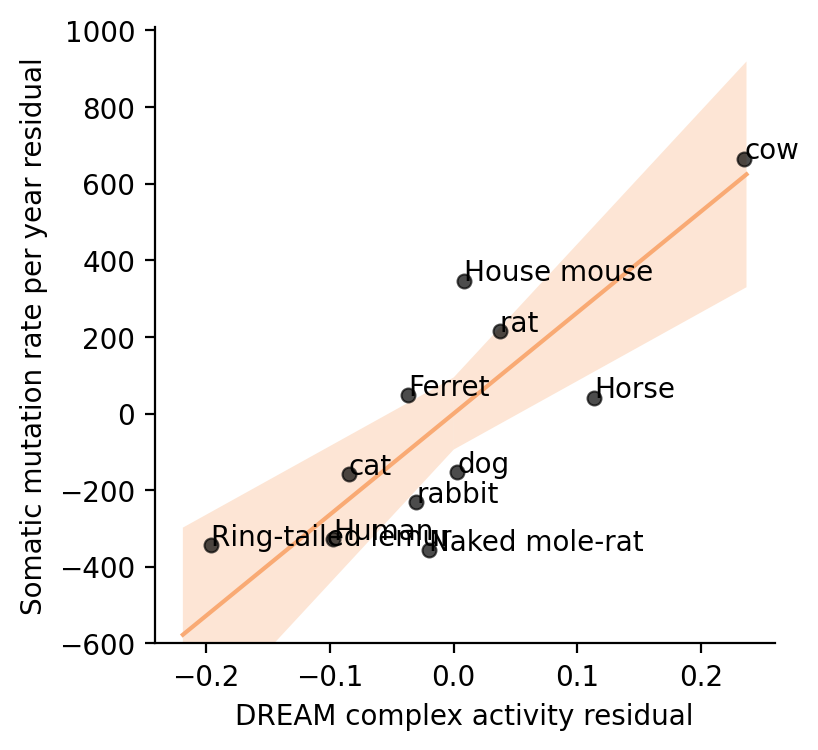

In [508]:

fig, axes = plt.subplots(1, 1, figsize=(4, 4))

tissue = 'Liver'#'Brain', 'Kidney', 
y = "Mean mutation rate (SBS/genome/year)" #lifespan_80percentile_HMD_species360"#
x = "DREAM_normalized_enrichment_score_resid"

to_use_df = liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue")


results = regress2(
    to_use_df['AW/g'],to_use_df[x]
    )
to_use_df[f'{x}_Weightresid'] =  to_use_df[x] - results['predict']

results = regress2(
    to_use_df['AW/g'], to_use_df[y]
    )
to_use_df[f'{y}_Weightresid'] =  to_use_df[y] - results['predict']

# plot line based on reduced major axis regression
results = regress2(
    _x = to_use_df[f'{x}_Weightresid'].values , _y = to_use_df[f'{y}_Weightresid'].values, _need_intercept = True
    )
slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
x_vals = np.linspace(to_use_df[f'{x}_Weightresid'].min(), to_use_df[f'{x}_Weightresid'].max(), 1000)
y_vals = slope * x_vals + intercept
axes.plot(x_vals, y_vals, color = organ_palette[tissue])

# until 0, use upper bound 1 and lowest bound2
x_vals1 = np.linspace(to_use_df[f'{x}_Weightresid'].min(), 0, 1000)
lower_bound1 = (slope - 1.96*std_err) * x_vals1 + (intercept - 1.96*std_intercept)
upper_bound1 = (slope - 1.96*std_err) * x_vals1 + (intercept + 1.96*std_intercept)
lower_bound2 = (slope + 1.96*std_err) * x_vals1 + (intercept - 1.96*std_intercept)
upper_bound2 = (slope + 1.96*std_err) * x_vals1 + (intercept + 1.96*std_intercept)
axes.fill_between(x_vals1, lower_bound2, upper_bound1, alpha=0.3, color=organ_palette[tissue],edgecolor = 'none')
# after 0, use upper bound 2 and lower bound 1
x_vals2 = np.linspace(0,to_use_df[f'{x}_Weightresid'].max(), 1000)
lower_bound1 = (slope - 1.96*std_err) * x_vals2 + (intercept - 1.96*std_intercept)
upper_bound1 = (slope - 1.96*std_err) * x_vals2 + (intercept + 1.96*std_intercept)
lower_bound2 = (slope + 1.96*std_err) * x_vals2 + (intercept - 1.96*std_intercept)
upper_bound2 = (slope + 1.96*std_err) * x_vals2 + (intercept + 1.96*std_intercept)
axes.fill_between(x_vals2, lower_bound1, upper_bound2, alpha=0.3, color=organ_palette[tissue],  edgecolor = 'none')

sns.pointplot(
    data = to_use_df,
    x = f'{x}_Weightresid', y = f'{y}_Weightresid',
    alpha = 0.7,
    linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1,color='black',errorbar=None, ax = axes, capsize = 3,
    orient = 'h'
)
sns.despine()
#plt.ylabel("DREAM complex activity residual")
#plt.xlabel("Maximum lifespan residual")
print(pearsonr(to_use_df[f'{x}_Weightresid'], to_use_df[f'{y}_Weightresid']))
print(spearmanr(to_use_df[f'{x}_Weightresid'], to_use_df[f'{y}_Weightresid']))

names_x = to_use_df.groupby(["Common_name"])[f'{x}_Weightresid'].mean()
names_y = to_use_df.groupby(["Common_name"])[f'{y}_Weightresid'].mean()
names_df = pd.concat([names_x, names_y], axis=1)
names_df.reset_index(inplace=True, drop=False)
# label each point with common name
for i, row in names_df.iterrows():
    axes.text(row[f'{x}_Weightresid'], row[f'{y}_Weightresid'], row['Common_name'], fontsize=10)
    
plt.ylabel("Somatic mutation rate per year residual")
plt.xlabel("DREAM complex activity residual")
plt.ylim(bottom = -600)
plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/DREAM_vs_mutations_weightResid_liver.svg", dpi = 300)

PearsonRResult(statistic=0.49094222925578146, pvalue=0.007984072280950778)
SignificanceResult(statistic=0.49918752537878575, pvalue=0.006845276824187039)


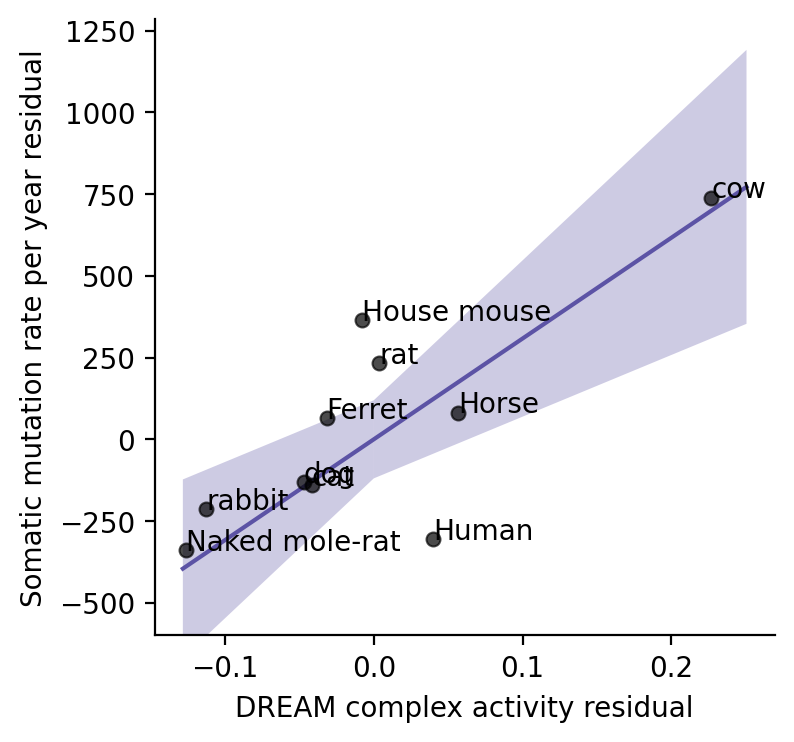

In [509]:

fig, axes = plt.subplots(1, 1, figsize=(4, 4))

tissue = 'Brain'#'Brain', 'Kidney', 
y = "Mean mutation rate (SBS/genome/year)" #lifespan_80percentile_HMD_species360"#
x = "DREAM_normalized_enrichment_score_resid"

to_use_df = liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue")


results = regress2(
    to_use_df['AW/g'],to_use_df[x]
    )
to_use_df[f'{x}_Weightresid'] =  to_use_df[x] - results['predict']

results = regress2(
    to_use_df['AW/g'], to_use_df[y]
    )
to_use_df[f'{y}_Weightresid'] =  to_use_df[y] - results['predict']

# plot line based on reduced major axis regression
results = regress2(
    _x = to_use_df[f'{x}_Weightresid'].values , _y = to_use_df[f'{y}_Weightresid'].values, _need_intercept = True
    )
slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
x_vals = np.linspace(to_use_df[f'{x}_Weightresid'].min(), to_use_df[f'{x}_Weightresid'].max(), 1000)
y_vals = slope * x_vals + intercept
axes.plot(x_vals, y_vals, color = organ_palette[tissue])

# until 0, use upper bound 1 and lowest bound2
x_vals1 = np.linspace(to_use_df[f'{x}_Weightresid'].min(), 0, 1000)
lower_bound1 = (slope - 1.96*std_err) * x_vals1 + (intercept - 1.96*std_intercept)
upper_bound1 = (slope - 1.96*std_err) * x_vals1 + (intercept + 1.96*std_intercept)
lower_bound2 = (slope + 1.96*std_err) * x_vals1 + (intercept - 1.96*std_intercept)
upper_bound2 = (slope + 1.96*std_err) * x_vals1 + (intercept + 1.96*std_intercept)
axes.fill_between(x_vals1, lower_bound2, upper_bound1, alpha=0.3, color=organ_palette[tissue],edgecolor = 'none')
# after 0, use upper bound 2 and lower bound 1
x_vals2 = np.linspace(0,to_use_df[f'{x}_Weightresid'].max(), 1000)
lower_bound1 = (slope - 1.96*std_err) * x_vals2 + (intercept - 1.96*std_intercept)
upper_bound1 = (slope - 1.96*std_err) * x_vals2 + (intercept + 1.96*std_intercept)
lower_bound2 = (slope + 1.96*std_err) * x_vals2 + (intercept - 1.96*std_intercept)
upper_bound2 = (slope + 1.96*std_err) * x_vals2 + (intercept + 1.96*std_intercept)
axes.fill_between(x_vals2, lower_bound1, upper_bound2, alpha=0.3, color=organ_palette[tissue],  edgecolor = 'none')

sns.pointplot(
    data = to_use_df,
    x = f'{x}_Weightresid', y = f'{y}_Weightresid',
    alpha = 0.7,
    linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1,color='black',errorbar=None, ax = axes, capsize = 3,
    orient = 'h'
)
sns.despine()
#plt.ylabel("DREAM complex activity residual")
#plt.xlabel("Maximum lifespan residual")
#plt.savefig("/cellar/users/zkoch/dream/figures/fig_cross_species/liver_weight_residuals.svg", dpi = 300)
print(pearsonr(to_use_df[f'{x}_Weightresid'], to_use_df[f'{y}_Weightresid']))
print(spearmanr(to_use_df[f'{x}_Weightresid'], to_use_df[f'{y}_Weightresid']))

names_x = to_use_df.groupby(["Common_name"])[f'{x}_Weightresid'].mean()
names_y = to_use_df.groupby(["Common_name"])[f'{y}_Weightresid'].mean()
names_df = pd.concat([names_x, names_y], axis=1)
names_df.reset_index(inplace=True, drop=False)
# label each point with common name
for i, row in names_df.iterrows():
    axes.text(row[f'{x}_Weightresid'], row[f'{y}_Weightresid'], row['Common_name'], fontsize=10)
    
plt.ylabel("Somatic mutation rate per year residual")
plt.xlabel("DREAM complex activity residual")
plt.ylim(bottom = -600)
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/cross_species/DREAM_vs_mutations_weightResid_brain.svg", dpi = 300)

PearsonRResult(statistic=-0.31252175169335344, pvalue=0.12008641159097719)
SignificanceResult(statistic=-0.020268183559119145, pvalue=0.9217140063960039)


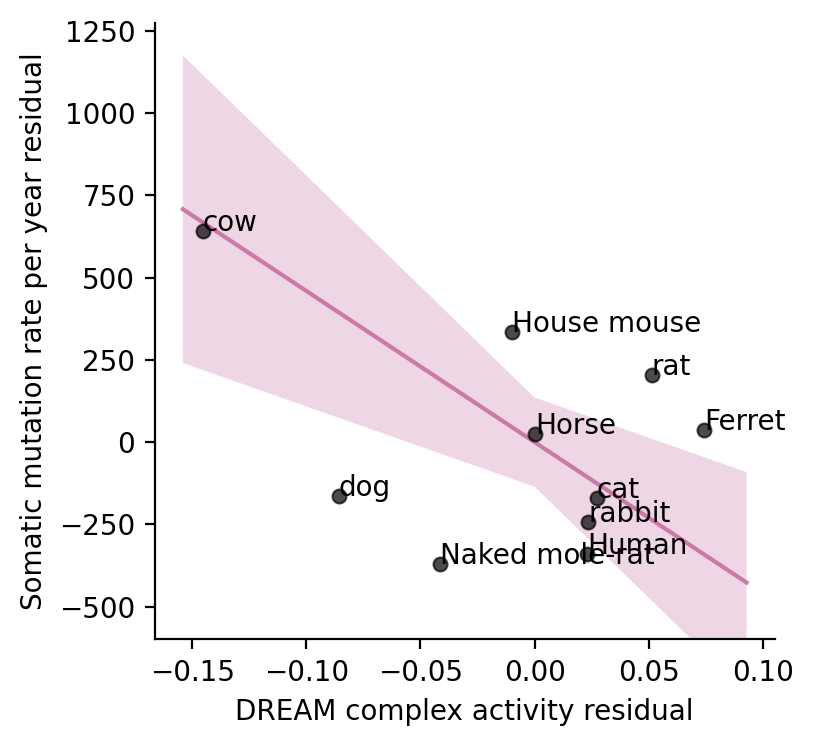

In [510]:

fig, axes = plt.subplots(1, 1, figsize=(4, 4))

tissue = 'Kidney'#'Brain', 'Kidney', 
y = "Mean mutation rate (SBS/genome/year)" #lifespan_80percentile_HMD_species360"#
x = "DREAM_normalized_enrichment_score_resid"

to_use_df = liu_2023.dream_expression.dropna(subset = ['Mean mutation rate (SBS/genome/year)']).query("Organ == @tissue")


results = regress2(
    to_use_df['AW/g'],to_use_df[x]
    )
to_use_df[f'{x}_Weightresid'] =  to_use_df[x] - results['predict']

results = regress2(
    to_use_df['AW/g'], to_use_df[y]
    )
to_use_df[f'{y}_Weightresid'] =  to_use_df[y] - results['predict']

# plot line based on reduced major axis regression
results = regress2(
    _x = to_use_df[f'{x}_Weightresid'].values , _y = to_use_df[f'{y}_Weightresid'].values, _need_intercept = True
    )
slope, intercept, r_value, std_err, std_intercept, predicted_vals = results['slope'], results['intercept'], results['r'], results['std_slope'], results['std_intercept'], results['predict']
x_vals = np.linspace(to_use_df[f'{x}_Weightresid'].min(), to_use_df[f'{x}_Weightresid'].max(), 1000)
y_vals = slope * x_vals + intercept
axes.plot(x_vals, y_vals, color = organ_palette[tissue])

# until 0, use upper bound 1 and lowest bound2
x_vals1 = np.linspace(to_use_df[f'{x}_Weightresid'].min(), 0, 1000)
lower_bound1 = (slope - 1.96*std_err) * x_vals1 + (intercept - 1.96*std_intercept)
upper_bound1 = (slope - 1.96*std_err) * x_vals1 + (intercept + 1.96*std_intercept)
lower_bound2 = (slope + 1.96*std_err) * x_vals1 + (intercept - 1.96*std_intercept)
upper_bound2 = (slope + 1.96*std_err) * x_vals1 + (intercept + 1.96*std_intercept)
axes.fill_between(x_vals1, lower_bound2, upper_bound1, alpha=0.3, color=organ_palette[tissue],edgecolor = 'none')
# after 0, use upper bound 2 and lower bound 1
x_vals2 = np.linspace(0,to_use_df[f'{x}_Weightresid'].max(), 1000)
lower_bound1 = (slope - 1.96*std_err) * x_vals2 + (intercept - 1.96*std_intercept)
upper_bound1 = (slope - 1.96*std_err) * x_vals2 + (intercept + 1.96*std_intercept)
lower_bound2 = (slope + 1.96*std_err) * x_vals2 + (intercept - 1.96*std_intercept)
upper_bound2 = (slope + 1.96*std_err) * x_vals2 + (intercept + 1.96*std_intercept)
axes.fill_between(x_vals2, lower_bound1, upper_bound2, alpha=0.3, color=organ_palette[tissue],  edgecolor = 'none')

sns.pointplot(
    data = to_use_df,
    x = f'{x}_Weightresid', y = f'{y}_Weightresid',
    alpha = 0.7,
    linestyle='none', native_scale=True, dodge=True,
    markersize = 5, linewidth = 1,color='black',errorbar=None, ax = axes, capsize = 3,
    orient = 'h'
)
sns.despine()
#plt.ylabel("DREAM complex activity residual")
#plt.xlabel("Maximum lifespan residual")
print(pearsonr(to_use_df[f'{x}_Weightresid'], to_use_df[f'{y}_Weightresid']))
print(spearmanr(to_use_df[f'{x}_Weightresid'], to_use_df[f'{y}_Weightresid']))

names_x = to_use_df.groupby(["Common_name"])[f'{x}_Weightresid'].mean()
names_y = to_use_df.groupby(["Common_name"])[f'{y}_Weightresid'].mean()
names_df = pd.concat([names_x, names_y], axis=1)
names_df.reset_index(inplace=True, drop=False)
# label each point with common name
for i, row in names_df.iterrows():
    axes.text(row[f'{x}_Weightresid'], row[f'{y}_Weightresid'], row['Common_name'], fontsize=10)
    
plt.ylabel("Somatic mutation rate per year residual")
plt.xlabel("DREAM complex activity residual")
plt.ylim(bottom = -600)
plt.savefig("/cellar/users/zkoch/dream/figures/supplementary/cross_species/DREAM_vs_mutations_weightResid_kidney.svg", dpi = 300)

# Treated cells (Harper et al. 2007)

In [ ]:
# Little brown bat: none (other Myotis tho)
# Fox squirrel: Scuirus niger to Sciurus_vulgaris
# Red Squirrel: none 
# North Amercian Porcupine: none (other porcupine tho)
# Deer Mouse: none

/tmp/ipykernel_3522117/716999664.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_dream_expression['DREAM_normalized_enrichment_score_resid_MLResid'] =  combined_dream_expression['DREAM_normalized_enrichment_score_resid'] - results['predict']


In [65]:
liu_2023.dream_expression['dset'] = 'liu_2023'
lu_2022.dream_expression['dset'] = 'lu_2022'
combined_dream_expression = pd.concat(
    [liu_2023.dream_expression,
     lu_2022.dream_expression.rename({'SPECIES':'Common_name', 'TISSUE': 'Organ', 'WEIGHT': 'AWg', 'MLS':'MLyrs'}, axis=1)],
    axis=0)
combined_dream_expression.loc[
    combined_dream_expression['Common_name'] == 'Deer mouse', 'Species'
    ] = 'P_maniculatus'
combined_dream_expression.loc[
    combined_dream_expression['Common_name'] == 'Red squirrel', 'Species'
] = 'Tamiasciurus_hudsonicus'

# DREAM normalized for ML DREAM_normalized_enrichment_score_resid too
results = regress2(
    combined_dream_expression.query("Organ == 'Liver'")['MLyrs'], combined_dream_expression.query("Organ == 'Liver'")['DREAM_normalized_enrichment_score_resid']
    )
combined_dream_expression['DREAM_normalized_enrichment_score_resid_MLResid'] =  combined_dream_expression['DREAM_normalized_enrichment_score_resid'] - results['predict'] 

/tmp/ipykernel_3522117/3108102629.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_dream_expression['DREAM_normalized_enrichment_score_resid_MLResid'] =  combined_dream_expression['DREAM_normalized_enrichment_score_resid'] - results['predict']


In [66]:
organ = 'Liver'
# read in harper data
harper_df = pd.read_csv("/cellar/users/zkoch/dream/data/harper_2007/Harper_2007.tsv", sep = '\t')

mean_dream_by_species = combined_dream_expression.query("Organ == @organ").groupby(
    'Species'
    )['DREAM_normalized_enrichment_score_resid'].mean()
mean_dreamMLres_by_species = combined_dream_expression.query("Organ == @organ").groupby(
    'Species'
    )['DREAM_normalized_enrichment_score_resid_MLResid'].mean()
weight_by_species = combined_dream_expression.groupby('Species')['AWg'].mean()


harper_df['mean_DREAM_normalized_enrichment_score_resid'] = harper_df['Species'].map(mean_dream_by_species)
harper_df['mean_DREAM_normalized_enrichment_score_resid_MLResid'] = harper_df['Species'].map(mean_dreamMLres_by_species)

harper_df['AWg'] = harper_df['Species'].map(weight_by_species)
harper_df['MLyrs'] = harper_df['Species'].map(combined_dream_expression.groupby('Species')['MLyrs'].mean())
#harper_df['MLres'] = harper_df['Species'].map(liu_2023.dream_expression.groupby('Species')['MLres'].mean())

# drop nan 
harper_df.dropna(subset = ['mean_DREAM_normalized_enrichment_score_resid'], inplace=True)
harper_df.reset_index(inplace=True, drop=True)

# select cols that don't start with SD
measurement_cols = [col for col in harper_df.columns[3:-2] if not col.startswith('SD')]

# get residuals with respect to weight
for col in measurement_cols:
    results = regress2(
        harper_df['AWg'], harper_df[col]
        )
    harper_df[f'{col}_WeightResid'] =  harper_df[col] - results['predict']


# fill nans with 0 because stdev of 1 sample is 0
harper_df.fillna(0, inplace=True)
# drop 
harper_df.query("Common_name != 'House Mouse (wild)'", inplace=True)

In [9]:
harper_df[['Max Lifespan (yr)', 'MLyrs']]

,Max Lifespan (yr),MLyrs
0,7.0,14.8
1,24.0,23.4
2,8.2,7.9
3,8.3,8.3
4,5.0,3.8
5,2.7,4.0


In [14]:
harper_df.sort_values('mean_DREAM_normalized_enrichment_score_resid')[['Common_name', '# Cell Lines','Species', 'mean_DREAM_normalized_enrichment_score_resid']]

,Common_name,# Cell Lines,Species,mean_DREAM_normalized_enrichment_score_resid
1,North American Beaver,1,Castor_canadensis,0.518703
0,Red Squirrel,9,Tamiasciurus_hudsonicus,0.536668
2,White-footed Mouse,7,Peromyscus_leucopus,0.544182
5,House Mouse (lab),9,Mus_musculus,0.593344
4,Norway Rat,6,Rattus_norvegicus,0.622277
3,Deer Mouse,5,P_maniculatus,0.831663


Cadmium (μM) 32.766666666666666 13.431927138972526 17 5.733333333333333 5.002665955934563 20
Heat (sec) 78.66666666666667 25.30480850220632 17 45.666666666666664 10.862780491200215 20
Paraquat (mM) 7.933333333333333 7.312546296149744 17 2.466666666666667 1.4011899704655801 20
H2O2 (μM) 53.666666666666664 18.850287354131588 17 55.333333333333336 41.05687112611806 20
MMS  (mM) 0.48333333333333334 0.16268579122549906 17 0.22666666666666668 0.1398809017223819 20
UV (J/m2) 162.0 111.34331292598283 17 68.0 43.734044709661454 20
Rotenone (μM) 42.666666666666664 28.827070610799147 17 11.666666666666666 18.684128737157284 20
Glucose (mg/mL) 0.13333333333333333 0.08164965809277261 17 0.17666666666666667 0.07348469228349536 20


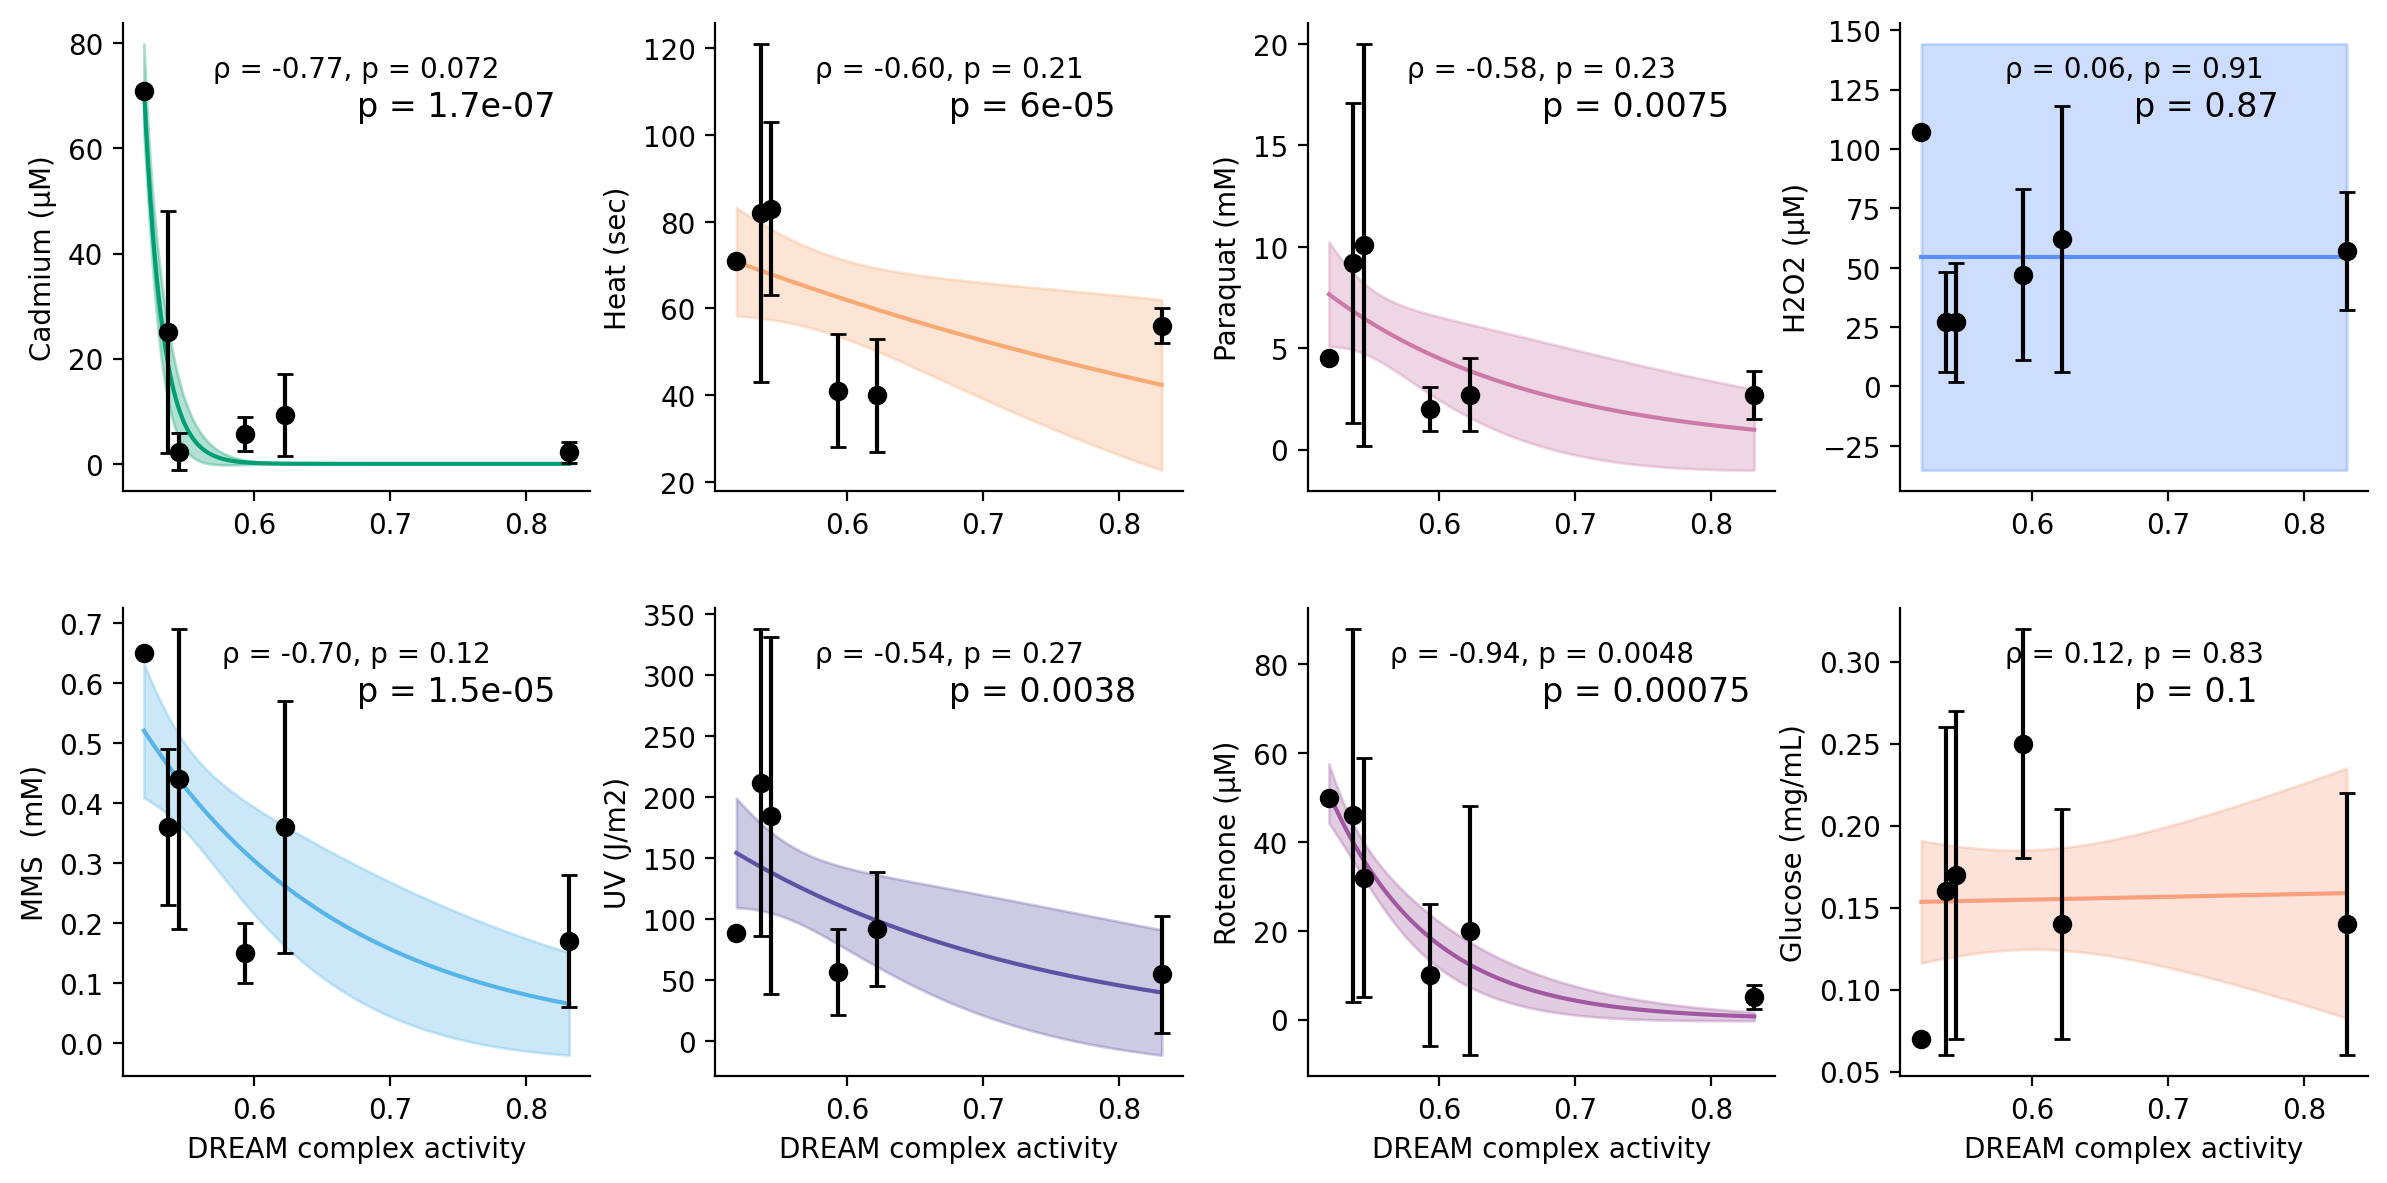

In [25]:
harper_df['DREAM_bin'] = pd.qcut(harper_df['mean_DREAM_normalized_enrichment_score_resid'], 2, labels = ['low', 'high'])
# pivot to long format
harper_df_long = pd.melt(
    harper_df, id_vars = ['Common_name', 'mean_DREAM_normalized_enrichment_score_resid', 'mean_DREAM_normalized_enrichment_score_resid_WeightResid', 'AWg', 'MLyrs', 'DREAM_bin'],
    value_vars = [col for col in harper_df.columns[3:] if not (col.startswith('SD') | col.endswith('WeightResid')) ], var_name = 'Treatment', value_name = 'LD50'
    )
harper_df_long.query("Treatment != 'Max Lifespan (yr)'", inplace=True)
# create a facet grid of pointplots, where each facet is a treatment, the x axis is mean_DREAM_normalized_enrichment_score_resid, y axis is the Measurement
g = sns.FacetGrid(
    harper_df_long, col = 'Treatment', col_wrap = 4,
    sharex = False, sharey = False, height = 3,
    hue = 'Treatment', palette = my_categorical_palette,
    #col_order = plot_order
    )

# set x label
g.set_xlabels("DREAM complex activity")
# remove titles
g.set_titles("")

treatment_order = harper_df_long['Treatment'].unique()
g.axes.flatten()
for i, ax in enumerate(g.axes.flatten()):
    this_treatment = treatment_order[i]
    mean_df = harper_df[
        ['mean_DREAM_normalized_enrichment_score_resid', this_treatment, f'SD {this_treatment}']
        ]
    
    # set color from my_categorical_palette
    color = my_categorical_palette[i]
    # use utils.plot_exponential to plot the exponential fit for each treatment
    utils.plot_exponential(
        mean_df, axes = ax, color = color, treatment_col = this_treatment, x_col = 'mean_DREAM_normalized_enrichment_score_resid'
    )
    # add the spearman rho and p value to the plot
    rho, p = spearmanr(mean_df['mean_DREAM_normalized_enrichment_score_resid'], mean_df[this_treatment], alternative='two-sided')
    ax.text(0.5, 0.9, f"ρ = {rho:.2f}, p = {p:.2}", ha='center', va='center', transform=ax.transAxes)
    # set y label to be the treatment
    ax.set_ylabel(this_treatment)
    
    # do a ttest between the two groups
    mean_low = harper_df_long.query("DREAM_bin == 'low' & Treatment == @this_treatment")['LD50'].mean()
    mean_high = harper_df_long.query("DREAM_bin == 'high' & Treatment == @this_treatment")['LD50'].mean()
    # get n from the original df
    n_low = harper_df.groupby('DREAM_bin', observed = False)['# Cell Lines'].sum()['low']
    n_high = harper_df.groupby('DREAM_bin', observed = False)['# Cell Lines'].sum()['high']
    # get std from the original df
    def aggregate_stds(stds : list):
        return np.sqrt(np.sum([std**2 for std in stds]) / len(stds))
    stdvs = harper_df.groupby('DREAM_bin', observed = False)[f'SD {this_treatment}'].apply(aggregate_stds)
    std_high = stdvs['high']
    std_low = stdvs['low']
    print(this_treatment, mean_low, std_low, n_low, mean_high, std_high, n_high)
    t_stat, p_value = ttest_ind_from_stats(mean_low, std_low, n_low, mean_high, std_high, n_high, alternative = 'two-sided', equal_var = False)
    ax.text(0.5, 0.8, f"p = {p_value:.2}", fontsize=12, transform=ax.transAxes)
    
    # plot actual data and stdevs
    ax.errorbar(
        mean_df['mean_DREAM_normalized_enrichment_score_resid'], mean_df[this_treatment],
        yerr=mean_df[f'SD {this_treatment}'], fmt='o', capsize=3,
        capthick=1, color='black', ecolor='black'
        )
# save as svg
g.savefig("/cellar/users/zkoch/dream/figures/fig_DNA_damage/harper_2007_dream_liver.svg", dpi = 300)